## Uplift Random Forest Benchmark

H2O cloud is inicialize before every run and shutdown after every run. Algorithm is firstly tested on Training performance and after on Evaluation performance.

* N = number of rows
* P = number of collumns
* max_depth = how big is the depth of the tree

Computer parameters:
 * Lenovo ThinkPad P53,
 * MS Windows 10 Pro x64,
 * Intel Core i7-9850H CPU @ 2.60GHz,
 * 6 cores and 12 threads,
 * 96.0 GB RAM.

In [1]:
import sys
sys.path.append("../../../../h2o-py/build/main") # path to h2o build

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import time
import math
import random
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators import H2OGradientBoostingEstimator
from causalml.dataset import make_uplift_classification

versionFromGradle='3.35.0',projectVersion='3.35.0.99999',branch='(HEAD detached at bd3753084c)',lastCommitHash='bd3753084c585e5d7dd3acd1070b25465c23c50f',gitDescribe='jenkins-master-5592-dirty',compiledOn='2021-10-14 17:49:30',compiledBy='potte'


The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.


In [3]:
# Notebook parameters

seed = 1234
ntrees = 100
attempt_per_thread = 10 # number of runs of the algorithm in the thread
threds = [12, 10, 8, 6, 4, 2, 1]
nbins = 1000
nbins_top_level=1024


In [4]:
def syntetic_data(N, P):
    train, x_names = make_uplift_classification(n_samples=N,
                                                treatment_name=['control', 'treatment'],
                                                n_classification_features=P,
                                                n_classification_informative=P,
                                                random_seed=seed
                                                )

    treatment_column = "treatment_group_key"
    response_column = "conversion"


    return train, x_names, treatment_column, response_column

def train_models(nthreads, data, start_cluster=True):
    if start_cluster:
        h2o.init(nthreads=nthreads)
    start = time.time()
    hf = h2o.H2OFrame(data)
    hf[treatment_column] = hf[treatment_column].asfactor()
    hf[response_column] = hf[response_column].asfactor()
    uplift_h2o = H2OGradientBoostingEstimator(        
                                                ntrees=ntrees,
                                                max_depth=max_depth,
                                                distribution="bernoulli",
                                                gainslift_bins=10,
                                                min_rows=10,
                                                nbins_top_level=nbins_top_level,
                                                nbins=nbins,
                                                seed=seed,
                                                sample_rate=0.99,
                                                score_tree_interval=ntrees+1
                                                )
    uplift_h2o.train(y=response_column, x=x_names, training_frame=hf)
    end = time.time()
    uplift_time = end - start
    print(f"Uplift Time: {uplift_time}s")
    start = time.time()
    rf_h2o = H2ORandomForestEstimator(        
                                      ntrees=ntrees,
                                      max_depth=max_depth,
                                      distribution="bernoulli",
                                      gainslift_bins=10,
                                      min_rows=10,
                                      nbins_top_level=nbins_top_level,
                                      nbins=nbins,
                                      seed=seed,
                                      sample_rate=0.99,
                                      binomial_double_trees=True,
                                      score_tree_interval=ntrees+1
                                    )
    rf_h2o.train(y=response_column, x=x_names, training_frame = hf)
    end = time.time()
    rf_time = end - start
    print(f"RF Time: {rf_time}s")
    if start_cluster:
        h2o.cluster().shutdown()
    return uplift_time, rf_time


def run_benchmark(data, start_cluster=True):
    all_times = []
    all_times_num_uplift = []
    all_times_num_rf = []
    for nthreads in threds:
        times_uplift = []
        times_rf = []
        for i in range(attempt_per_thread):
            uplift_time, rf_time = train_models(nthreads, data, start_cluster)
            times_uplift.append(uplift_time)
            times_rf.append(rf_time)
        print(f"Uplift {np.mean(times_uplift)}s")
        print(f"RF {np.mean(times_rf)}s")
        all_times_num_uplift.append(times_uplift)
        all_times_num_rf.append(times_rf)
        all_times.append(f"thread {nthreads} - Uplift {np.mean(times_uplift)}s and RF {np.mean(times_rf)}s")

    uplift_means = dict()
    rf_means = dict()
    for i, nthreads in enumerate(threds):
        print(f"{nthreads} - Uplift = {np.mean(all_times_num_uplift[i])}, RF = {np.mean(all_times_num_rf[i])}")
        uplift_means[nthreads] = np.mean(all_times_num_uplift[i])
        rf_means[nthreads] = np.mean(all_times_num_rf[i])
    
    return uplift_means, rf_means
        
    
def plot_result(eif_means, if_means):
    data = {"x":[], "y": [], "label":[]}
    for label, coord in eif_means.items():
        data["x"].append(label)
        data["y"].append(coord)

    data_if = {"x":[], "y": [], "label":[]}
    for label, coord in if_means.items():
        data_if["x"].append(label)
        data_if["y"].append(coord)    

    fig=plt.figure(figsize=(8,10))
    fig.add_subplot(111)
    plt.plot(data['x'], data['y'], '-', label="GBM", linewidth=3, color="goldenrod")
    plt.plot(data_if['x'], data_if['y'], '-', label="RF", linewidth=3, color="red")
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"Uplift Random Forest - training benchmark\nModel: N = {N}; P = {P}; ntrees = {ntrees};  max_depth = {max_depth}")
    plt.savefig(f"h2o-scale-gbm-perf_{max_depth}_{N}_{coord}.png", bbox_inches='tight', pad_inches=.05)
    plt.show()



## Training stage

In [5]:
max_depths = []

In [6]:
N = 100000
P = 20
max_depth = 8
max_depths.append(max_depth)

df, x_names, treatment_column, response_column = syntetic_data(N, P)

In [7]:
gbm_time7, rf_time7 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphoavp7a3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphoavp7a3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphoavp7a3\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 minutes
H2O_cluster_name:,H2O_from_python_potte_l117rx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 23.321125745773315s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.250237226486206s
H2O session _sid_852b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpac9h6w0a
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpac9h6w0a\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpac9h6w0a\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 minutes
H2O_cluster_name:,H2O_from_python_potte_wi99mr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 23.364381551742554s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.203302145004272s
H2O session _sid_9b61 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjde4wbl9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjde4wbl9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjde4wbl9\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 minutes
H2O_cluster_name:,H2O_from_python_potte_tbt9ni
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 23.077933311462402s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.2336585521698s
H2O session _sid_b1a0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgg_aygg1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgg_aygg1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgg_aygg1\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,5 minutes
H2O_cluster_name:,H2O_from_python_potte_qelx02
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 23.001201391220093s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.67640495300293s
H2O session _sid_bdec closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp33znpr98
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp33znpr98\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp33znpr98\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,5 minutes
H2O_cluster_name:,H2O_from_python_potte_ywhjd1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 22.142144918441772s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.813750743865967s
H2O session _sid_a2e3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprrtfvbdg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprrtfvbdg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprrtfvbdg\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,6 minutes
H2O_cluster_name:,H2O_from_python_potte_x5nhtl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 21.583298444747925s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.423100709915161s
H2O session _sid_9d1d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpuysvuv0j
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpuysvuv0j\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpuysvuv0j\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,7 minutes
H2O_cluster_name:,H2O_from_python_potte_1cod7z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 21.2308087348938s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.1798574924469s
H2O session _sid_8f9a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_lakp2aa
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_lakp2aa\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_lakp2aa\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 minutes
H2O_cluster_name:,H2O_from_python_potte_wrr4m1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 23.99357557296753s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.352012634277344s
H2O session _sid_9756 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdj59n3yh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdj59n3yh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdj59n3yh\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 minutes
H2O_cluster_name:,H2O_from_python_potte_q01m48
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 21.858084440231323s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.457390069961548s
H2O session _sid_8571 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwoi9hmvo
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwoi9hmvo\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwoi9hmvo\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 minutes
H2O_cluster_name:,H2O_from_python_potte_8z0jfj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 21.22775626182556s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.675375461578369s
H2O session _sid_a775 closed.
Uplift 22.480031037330626s
RF 7.82650899887085s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpruf020js
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpruf020js\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpruf020js\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,11 minutes
H2O_cluster_name:,H2O_from_python_potte_3t16s3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 19.998539924621582s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.553717851638794s
H2O session _sid_8e17 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp39o_4s6h
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp39o_4s6h\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp39o_4s6h\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,12 minutes
H2O_cluster_name:,H2O_from_python_potte_35vowt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 20.676689624786377s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.644712686538696s
H2O session _sid_9e64 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6_t4n5_y
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6_t4n5_y\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6_t4n5_y\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 minutes
H2O_cluster_name:,H2O_from_python_potte_olgnpp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 20.243875741958618s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.754599332809448s
H2O session _sid_8f8e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpc271a6kq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpc271a6kq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpc271a6kq\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 minutes
H2O_cluster_name:,H2O_from_python_potte_sdyzrl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 19.908586978912354s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.723557949066162s
H2O session _sid_afe9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpyhqeftnq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpyhqeftnq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpyhqeftnq\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 minutes
H2O_cluster_name:,H2O_from_python_potte_5mynql
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 20.02908706665039s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.508988380432129s
H2O session _sid_a4aa closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnkqpxp92
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnkqpxp92\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnkqpxp92\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,15 minutes
H2O_cluster_name:,H2O_from_python_potte_vu1rfi
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 20.000969648361206s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.540907621383667s
H2O session _sid_87e7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpk7tf8ioo
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpk7tf8ioo\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpk7tf8ioo\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,16 minutes
H2O_cluster_name:,H2O_from_python_potte_rm6285
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 19.96518611907959s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.5477821826934814s
H2O session _sid_8a82 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpr1baimk4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpr1baimk4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpr1baimk4\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,17 minutes
H2O_cluster_name:,H2O_from_python_potte_857lfn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 20.050814867019653s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.08403754234314s
H2O session _sid_993f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp24kmb22r
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp24kmb22r\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp24kmb22r\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,18 minutes
H2O_cluster_name:,H2O_from_python_potte_guo8fs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 19.96979594230652s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.076542615890503s
H2O session _sid_97eb closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxbu68y5d
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxbu68y5d\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxbu68y5d\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,19 minutes
H2O_cluster_name:,H2O_from_python_potte_w520xk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 20.16215229034424s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 6.886660575866699s
H2O session _sid_8cd3 closed.
Uplift 20.100569820404054s
RF 7.432150673866272s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpg57g6f_v
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpg57g6f_v\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpg57g6f_v\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,19 minutes
H2O_cluster_name:,H2O_from_python_potte_v49dj1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 18.83702564239502s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 6.882274627685547s
H2O session _sid_a714 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmua811ue
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmua811ue\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmua811ue\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 minutes
H2O_cluster_name:,H2O_from_python_potte_ejgo9t
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 19.09289789199829s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.43781304359436s
H2O session _sid_8781 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5uvwm1y2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5uvwm1y2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5uvwm1y2\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,21 minutes
H2O_cluster_name:,H2O_from_python_potte_k59la7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 19.611326456069946s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.480886459350586s
H2O session _sid_9967 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjoho45w2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjoho45w2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjoho45w2\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,22 minutes
H2O_cluster_name:,H2O_from_python_potte_mnurjl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 19.291335344314575s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.4631688594818115s
H2O session _sid_8c07 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpth2tflhb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpth2tflhb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpth2tflhb\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,23 minutes
H2O_cluster_name:,H2O_from_python_potte_9dfxf1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 19.393897771835327s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.430567741394043s
H2O session _sid_ad4a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnugmg434
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnugmg434\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnugmg434\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,24 minutes
H2O_cluster_name:,H2O_from_python_potte_snzv2b
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 19.757807970046997s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.448385238647461s
H2O session _sid_a920 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcnrc8yxv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcnrc8yxv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcnrc8yxv\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,24 minutes
H2O_cluster_name:,H2O_from_python_potte_cgwocp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 19.54223108291626s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.454535245895386s
H2O session _sid_8def closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp06urfhvw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp06urfhvw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp06urfhvw\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,25 minutes
H2O_cluster_name:,H2O_from_python_potte_j60xd4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 19.66311764717102s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.490884304046631s
H2O session _sid_9361 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsn1_x0ub
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsn1_x0ub\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpsn1_x0ub\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,26 minutes
H2O_cluster_name:,H2O_from_python_potte_meqx1d
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 19.557900428771973s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.358062267303467s
H2O session _sid_9b28 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwawefjgz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwawefjgz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwawefjgz\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,27 minutes
H2O_cluster_name:,H2O_from_python_potte_ajmtc2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 20.292216777801514s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.5882887840271s
H2O session _sid_947f closed.
Uplift 19.50397570133209s
RF 7.403486657142639s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3fj39vso
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3fj39vso\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3fj39vso\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,28 minutes
H2O_cluster_name:,H2O_from_python_potte_k4kpcn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 18.921116590499878s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.636127471923828s
H2O session _sid_9fab closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0ommgw3y
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0ommgw3y\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0ommgw3y\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,29 minutes
H2O_cluster_name:,H2O_from_python_potte_0ye4x2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 19.235644578933716s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.5641114711761475s
H2O session _sid_bf82 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4egfafhf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4egfafhf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4egfafhf\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,30 minutes
H2O_cluster_name:,H2O_from_python_potte_6m7z5b
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 18.91609764099121s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.591278791427612s
H2O session _sid_9540 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4rwnj58m
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4rwnj58m\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4rwnj58m\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,30 minutes
H2O_cluster_name:,H2O_from_python_potte_m2c1de
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 18.56598949432373s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.540670156478882s
H2O session _sid_b825 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpeiw1azv_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpeiw1azv_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpeiw1azv_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,31 minutes
H2O_cluster_name:,H2O_from_python_potte_ykqrnl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 19.603771448135376s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.527716398239136s
H2O session _sid_a861 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpi8vhea5s
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpi8vhea5s\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpi8vhea5s\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,32 minutes
H2O_cluster_name:,H2O_from_python_potte_9omdus
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 18.90378499031067s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.712047576904297s
H2O session _sid_9f6e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcw1ujc2b
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcw1ujc2b\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcw1ujc2b\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,33 minutes
H2O_cluster_name:,H2O_from_python_potte_afuci4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 19.049152851104736s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.554358720779419s
H2O session _sid_ba86 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpr2znucty
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpr2znucty\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpr2znucty\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,34 minutes
H2O_cluster_name:,H2O_from_python_potte_gxyy3y
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 19.39793372154236s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.643874406814575s
H2O session _sid_a239 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpe_99tq78
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpe_99tq78\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpe_99tq78\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,35 minutes
H2O_cluster_name:,H2O_from_python_potte_2t9532
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 19.0408616065979s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.715290546417236s
H2O session _sid_a07d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp65e05mf1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp65e05mf1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp65e05mf1\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,35 minutes
H2O_cluster_name:,H2O_from_python_potte_euflb3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 18.65260910987854s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.428873777389526s
H2O session _sid_b9f9 closed.
Uplift 19.02869620323181s
RF 7.591434931755066s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpr72tt7n8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpr72tt7n8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpr72tt7n8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,36 minutes
H2O_cluster_name:,H2O_from_python_potte_x72ie2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 20.000880241394043s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.746365070343018s
H2O session _sid_8ab2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdas5hgh_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdas5hgh_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdas5hgh_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,37 minutes
H2O_cluster_name:,H2O_from_python_potte_n3w86d
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 20.00340461730957s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.725495100021362s
H2O session _sid_8c17 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_jli4th8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_jli4th8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_jli4th8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,38 minutes
H2O_cluster_name:,H2O_from_python_potte_px8xxr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 19.980924606323242s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.7434823513031s
H2O session _sid_8d7c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpf20pwitn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpf20pwitn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpf20pwitn\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,39 minutes
H2O_cluster_name:,H2O_from_python_potte_27rwr4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 19.94651436805725s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.762080907821655s
H2O session _sid_b198 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpe0u0m14h
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpe0u0m14h\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpe0u0m14h\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,40 minutes
H2O_cluster_name:,H2O_from_python_potte_86ap60
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 19.922691583633423s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.731407642364502s
H2O session _sid_b1b4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpt74cg4rx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpt74cg4rx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpt74cg4rx\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,41 minutes
H2O_cluster_name:,H2O_from_python_potte_aj88k3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 19.97533369064331s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.655375003814697s
H2O session _sid_af4a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpq2ljo2se
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpq2ljo2se\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpq2ljo2se\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,42 minutes
H2O_cluster_name:,H2O_from_python_potte_xgnocn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 20.713087558746338s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.823336601257324s
H2O session _sid_87e6 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp13fq4izu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp13fq4izu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp13fq4izu\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,42 minutes
H2O_cluster_name:,H2O_from_python_potte_eglt0q
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 20.779211044311523s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.697509527206421s
H2O session _sid_aad3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpglt1iln6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpglt1iln6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpglt1iln6\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,43 minutes
H2O_cluster_name:,H2O_from_python_potte_tsy9z5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 20.597851753234863s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.787523746490479s
H2O session _sid_a7d7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1iiz87pn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1iiz87pn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1iiz87pn\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,44 minutes
H2O_cluster_name:,H2O_from_python_potte_3b20g9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 20.687626838684082s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.834707975387573s
H2O session _sid_83e2 closed.
Uplift 20.260752630233764s
RF 8.750728392601014s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcqelvdh7
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcqelvdh7\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcqelvdh7\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server a

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,45 minutes
H2O_cluster_name:,H2O_from_python_potte_u7c4cx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 27.45662546157837s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 14.582797050476074s
H2O session _sid_91fd closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppakkbc5w
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppakkbc5w\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppakkbc5w\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,46 minutes
H2O_cluster_name:,H2O_from_python_potte_9ai83m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 27.745418548583984s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 14.711059331893921s
H2O session _sid_87ee closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpf5ejtcr_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpf5ejtcr_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpf5ejtcr_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,47 minutes
H2O_cluster_name:,H2O_from_python_potte_x6ke9m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 27.572927951812744s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 14.629849910736084s
H2O session _sid_b399 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfyb7m5e5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfyb7m5e5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfyb7m5e5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,48 minutes
H2O_cluster_name:,H2O_from_python_potte_bh9qze
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 27.402501344680786s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 14.863418817520142s
H2O session _sid_9a4e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcp2ar4t0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcp2ar4t0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcp2ar4t0\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,50 minutes
H2O_cluster_name:,H2O_from_python_potte_rqupgq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 27.486676931381226s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 14.047614812850952s
H2O session _sid_8479 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpiyf9hs7h
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpiyf9hs7h\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpiyf9hs7h\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,51 minutes
H2O_cluster_name:,H2O_from_python_potte_9en9g2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |███████████████████████████████████████████████████████| (done) 100%
Uplift Time: 27.296550989151s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 15.083837032318115s
H2O session _sid_8110 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplcjjnqz1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplcjjnqz1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplcjjnqz1\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,52 minutes
H2O_cluster_name:,H2O_from_python_potte_26sxyx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 26.798293590545654s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 14.0816969871521s
H2O session _sid_a361 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbpyfdyop
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbpyfdyop\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbpyfdyop\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,53 minutes
H2O_cluster_name:,H2O_from_python_potte_c13kkk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 27.335410356521606s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 14.83060359954834s
H2O session _sid_a75a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpws0vyd16
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpws0vyd16\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpws0vyd16\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,54 minutes
H2O_cluster_name:,H2O_from_python_potte_0qfxmw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 27.306324005126953s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 14.786969184875488s
H2O session _sid_aa0c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwvhmmzjk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwvhmmzjk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwvhmmzjk\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,55 minutes
H2O_cluster_name:,H2O_from_python_potte_m5y356
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 27.162622451782227s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 14.778062582015991s
H2O session _sid_9d14 closed.
Uplift 27.356335163116455s
RF 14.63959093093872s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpye0ixpe2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpye0ixpe2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpye0ixpe2\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,56 minutes
H2O_cluster_name:,H2O_from_python_potte_6hc8n8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 42.552167654037476s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 26.211844444274902s
H2O session _sid_834a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnkhjzr2z
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnkhjzr2z\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnkhjzr2z\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,58 minutes
H2O_cluster_name:,H2O_from_python_potte_d2xwjy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 42.508628368377686s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 27.138614892959595s
H2O session _sid_aa19 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp46q4jalz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp46q4jalz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp46q4jalz\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,59 minutes
H2O_cluster_name:,H2O_from_python_potte_ctault
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 42.1148796081543s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 25.884915590286255s
H2O session _sid_8cb6 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkemddtav
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkemddtav\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkemddtav\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 1 minute
H2O_cluster_name:,H2O_from_python_potte_qi83a2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 42.884721994400024s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 25.987107276916504s
H2O session _sid_9c59 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmps19yrw2h
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmps19yrw2h\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmps19yrw2h\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 2 minutes
H2O_cluster_name:,H2O_from_python_potte_k34qhz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 42.560781478881836s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 26.401422262191772s
H2O session _sid_8943 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwh484ojs
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwh484ojs\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwh484ojs\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 4 minutes
H2O_cluster_name:,H2O_from_python_potte_cnbgpa
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 43.09003663063049s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 26.17824101448059s
H2O session _sid_b056 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqtovqf5z
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqtovqf5z\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqtovqf5z\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 5 minutes
H2O_cluster_name:,H2O_from_python_potte_ewbaf9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 42.24239492416382s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 25.917882442474365s
H2O session _sid_8af6 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmposuclaqa
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmposuclaqa\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmposuclaqa\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 7 minutes
H2O_cluster_name:,H2O_from_python_potte_lk4ndv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 42.865973472595215s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 26.018862009048462s
H2O session _sid_8547 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_s0dr05k
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_s0dr05k\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_s0dr05k\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 8 minutes
H2O_cluster_name:,H2O_from_python_potte_uit3mj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 42.982574701309204s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 26.63542675971985s
H2O session _sid_8082 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9uy_br_9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9uy_br_9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9uy_br_9\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 10 minutes
H2O_cluster_name:,H2O_from_python_potte_8nmzvr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 42.875649213790894s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 26.792534828186035s
H2O session _sid_b633 closed.
Uplift 42.66778080463409s
RF 26.316685152053832s
12 - Uplift = 22.480031037330626, RF = 7.82650899887085
10 - Uplift = 20.100569820404054, RF = 7.432150673866272
8 - Uplift = 19.50397570133209, RF = 7.403486657142639
6 - Uplift = 19.02869620323181, RF = 7.591434931755066
4 - Uplift = 20.260752630233764, RF = 8.750728392601014
2 - Uplift = 27.356335163116455, RF = 14.63959093093872
1 - Uplift = 42.66778080463409, RF = 26.316685152053832


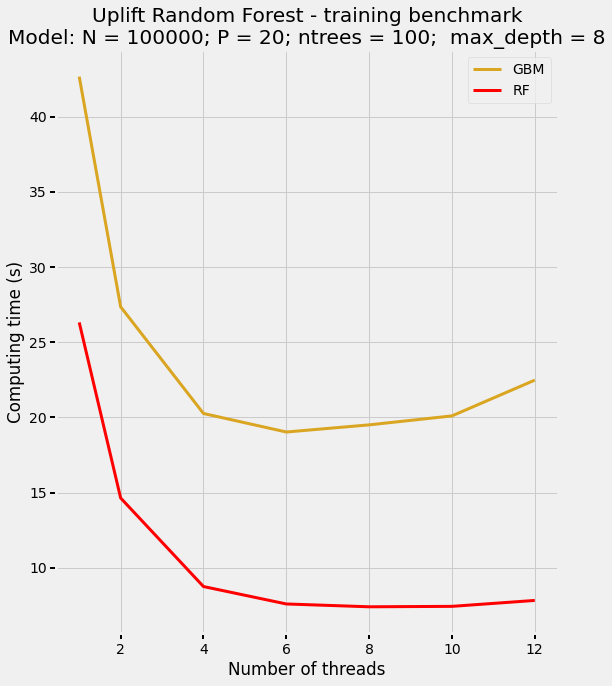

In [8]:
plot_result(gbm_time7, rf_time7)

In [9]:
N = 100000
P = 20
max_depth = 16
max_depths.append(max_depth)

df, x_names, treatment_column, response_column = syntetic_data(N, P)

In [10]:
gbm_time8, rf_time8 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpem60pg9v
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpem60pg9v\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpem60pg9v\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 12 minutes
H2O_cluster_name:,H2O_from_python_potte_78brml
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 174.14313459396362s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 61.21221041679382s
H2O session _sid_bbc1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplt381w4s
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplt381w4s\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplt381w4s\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 16 minutes
H2O_cluster_name:,H2O_from_python_potte_vfh4ua
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 169.88472747802734s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 61.995375871658325s
H2O session _sid_8f9b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7h3sdd42
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7h3sdd42\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7h3sdd42\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 20 minutes
H2O_cluster_name:,H2O_from_python_potte_8b8ewi
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 169.47234463691711s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 61.825502157211304s
H2O session _sid_9452 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp83kzqot3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp83kzqot3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp83kzqot3\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 24 minutes
H2O_cluster_name:,H2O_from_python_potte_zztigu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 169.07836055755615s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 63.29206466674805s
H2O session _sid_bee5 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvie0293a
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvie0293a\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvie0293a\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 29 minutes
H2O_cluster_name:,H2O_from_python_potte_fzhjbk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 170.32078647613525s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 61.80095815658569s
H2O session _sid_bc83 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6zdk3_od
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6zdk3_od\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6zdk3_od\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 33 minutes
H2O_cluster_name:,H2O_from_python_potte_28avhk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 169.69977521896362s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 61.97614765167236s
H2O session _sid_a8e0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpigzxjfo5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpigzxjfo5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpigzxjfo5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 37 minutes
H2O_cluster_name:,H2O_from_python_potte_ch7tv4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 169.44439029693604s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 62.17159819602966s
H2O session _sid_9359 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvt01rroa
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvt01rroa\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvt01rroa\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 42 minutes
H2O_cluster_name:,H2O_from_python_potte_bowwh0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 171.59141087532043s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 62.04516911506653s
H2O session _sid_b8ed closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmph_z8_lvt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmph_z8_lvt\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmph_z8_lvt\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 46 minutes
H2O_cluster_name:,H2O_from_python_potte_l180vz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 168.9246120452881s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 60.798619508743286s
H2O session _sid_b760 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpabwgftys
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpabwgftys\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpabwgftys\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 50 minutes
H2O_cluster_name:,H2O_from_python_potte_oltefh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 169.24662923812866s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 61.82551956176758s
H2O session _sid_ba0a closed.
Uplift 170.18061714172364s
RF 61.89431653022766s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0zklf7_n
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0zklf7_n\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0zklf7_n\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server a

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 54 minutes
H2O_cluster_name:,H2O_from_python_potte_z1v4yy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 154.39280915260315s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 57.525970697402954s
H2O session _sid_9c42 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpf3l39_wq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpf3l39_wq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpf3l39_wq\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 58 minutes
H2O_cluster_name:,H2O_from_python_potte_cxlqz2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 155.7673056125641s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 57.5825777053833s
H2O session _sid_a8de closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpp4wg4df3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpp4wg4df3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpp4wg4df3\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 2 minutes
H2O_cluster_name:,H2O_from_python_potte_5s7x3n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 154.9369411468506s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 56.622265100479126s
H2O session _sid_ad0d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1o4qyv0t
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1o4qyv0t\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1o4qyv0t\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 6 minutes
H2O_cluster_name:,H2O_from_python_potte_wvvyy9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 155.81473112106323s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 57.43515682220459s
H2O session _sid_804b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpt8lec337
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpt8lec337\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpt8lec337\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 10 minutes
H2O_cluster_name:,H2O_from_python_potte_vbibae
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 153.93307495117188s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 57.56292247772217s
H2O session _sid_91fe closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5w0l0_7p
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5w0l0_7p\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5w0l0_7p\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 14 minutes
H2O_cluster_name:,H2O_from_python_potte_8rb252
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 153.90534782409668s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 56.61056303977966s
H2O session _sid_9ac4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpylnn7sas
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpylnn7sas\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpylnn7sas\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 18 minutes
H2O_cluster_name:,H2O_from_python_potte_jggd85
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 154.94560289382935s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 57.404189586639404s
H2O session _sid_a0d6 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9h0vr6eb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9h0vr6eb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9h0vr6eb\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 22 minutes
H2O_cluster_name:,H2O_from_python_potte_baeltg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 156.09806108474731s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 56.685847759246826s
H2O session _sid_8984 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8x7uy24a
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8x7uy24a\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8x7uy24a\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 26 minutes
H2O_cluster_name:,H2O_from_python_potte_3ra8s7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 156.21629667282104s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 57.08181428909302s
H2O session _sid_a28c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqp1mun0c
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqp1mun0c\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqp1mun0c\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 30 minutes
H2O_cluster_name:,H2O_from_python_potte_gmy67k
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 155.22222256660461s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 56.569377183914185s
H2O session _sid_8324 closed.
Uplift 155.1232393026352s
RF 57.10806846618652s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpezrgtgof
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpezrgtgof\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpezrgtgof\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server a

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 34 minutes
H2O_cluster_name:,H2O_from_python_potte_cdc6pp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 139.99550032615662s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 52.81943941116333s
H2O session _sid_b343 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7n3bzp_6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7n3bzp_6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7n3bzp_6\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 37 minutes
H2O_cluster_name:,H2O_from_python_potte_qto6r5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 143.01595664024353s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 53.48068833351135s
H2O session _sid_a428 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpt1il03y6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpt1il03y6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpt1il03y6\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 41 minutes
H2O_cluster_name:,H2O_from_python_potte_mgr8sk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 143.0920147895813s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 52.82470464706421s
H2O session _sid_ac33 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptqwq8zt6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptqwq8zt6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptqwq8zt6\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 45 minutes
H2O_cluster_name:,H2O_from_python_potte_ueuf67
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 142.16296982765198s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 52.69075894355774s
H2O session _sid_86d0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1lok_rme
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1lok_rme\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1lok_rme\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 48 minutes
H2O_cluster_name:,H2O_from_python_potte_u914gg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 141.8572657108307s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 52.702810525894165s
H2O session _sid_a171 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpi74me1gz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpi74me1gz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpi74me1gz\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 52 minutes
H2O_cluster_name:,H2O_from_python_potte_ewyq8g
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 142.38516545295715s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 53.595895290374756s
H2O session _sid_ae11 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpd83pef1x
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpd83pef1x\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpd83pef1x\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 56 minutes
H2O_cluster_name:,H2O_from_python_potte_2jt74i
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 143.19205403327942s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 54.82514309883118s
H2O session _sid_bc11 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpd9dfiwoq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpd9dfiwoq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpd9dfiwoq\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 59 minutes
H2O_cluster_name:,H2O_from_python_potte_8qv9jr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 143.68796610832214s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 53.25196194648743s
H2O session _sid_9e3c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpl5cgbv5q
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpl5cgbv5q\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpl5cgbv5q\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 3 minutes
H2O_cluster_name:,H2O_from_python_potte_nsjjmn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 140.20904111862183s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 52.80023264884949s
H2O session _sid_aae2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpeor3bbmb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpeor3bbmb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpeor3bbmb\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 7 minutes
H2O_cluster_name:,H2O_from_python_potte_109d9z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 143.50260996818542s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 52.978407859802246s
H2O session _sid_b541 closed.
Uplift 142.310054397583s
RF 53.19700427055359s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphdz1qsff
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphdz1qsff\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphdz1qsff\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 10 minutes
H2O_cluster_name:,H2O_from_python_potte_fs6yd9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 134.53894782066345s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 49.45602297782898s
H2O session _sid_9917 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppp2rtzqf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppp2rtzqf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppp2rtzqf\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 14 minutes
H2O_cluster_name:,H2O_from_python_potte_qxcp3x
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 133.26473212242126s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 49.56074285507202s
H2O session _sid_aacf closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsg2ohm6c
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsg2ohm6c\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpsg2ohm6c\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 17 minutes
H2O_cluster_name:,H2O_from_python_potte_6a33ys
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 134.12482857704163s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 49.4584105014801s
H2O session _sid_9d97 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp56_o_gcq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp56_o_gcq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp56_o_gcq\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 21 minutes
H2O_cluster_name:,H2O_from_python_potte_12x5sl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 134.30313634872437s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 49.34910845756531s
H2O session _sid_aca5 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvcsnhhgn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvcsnhhgn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvcsnhhgn\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 24 minutes
H2O_cluster_name:,H2O_from_python_potte_avpm1f
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 134.16666984558105s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 52.160956382751465s
H2O session _sid_998a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpus5n15hr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpus5n15hr\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpus5n15hr\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 28 minutes
H2O_cluster_name:,H2O_from_python_potte_4lz06u
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 134.27149391174316s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 49.383238077163696s
H2O session _sid_9410 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_wlbtt4c
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_wlbtt4c\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_wlbtt4c\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 31 minutes
H2O_cluster_name:,H2O_from_python_potte_sdcuve
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 133.44436860084534s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 49.50118374824524s
H2O session _sid_b076 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpk_ldrpz2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpk_ldrpz2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpk_ldrpz2\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 34 minutes
H2O_cluster_name:,H2O_from_python_potte_97bdrq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 134.54865145683289s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 50.30577325820923s
H2O session _sid_91f9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1e91h_zj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1e91h_zj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1e91h_zj\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 38 minutes
H2O_cluster_name:,H2O_from_python_potte_fhnw4m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 134.46135997772217s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 49.716843366622925s
H2O session _sid_8062 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpt2q5rhw0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpt2q5rhw0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpt2q5rhw0\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 41 minutes
H2O_cluster_name:,H2O_from_python_potte_8a2kw2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 134.01382493972778s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 49.56036591529846s
H2O session _sid_84c7 closed.
Uplift 134.1138013601303s
RF 49.84526455402374s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpifwtamf7
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpifwtamf7\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpifwtamf7\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 45 minutes
H2O_cluster_name:,H2O_from_python_potte_nedk33
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 124.1072449684143s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 51.62199926376343s
H2O session _sid_883c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfdgm_ayg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfdgm_ayg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfdgm_ayg\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 48 minutes
H2O_cluster_name:,H2O_from_python_potte_y77898
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 124.09391975402832s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 51.7546546459198s
H2O session _sid_91af closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5b7p_3ga
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5b7p_3ga\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5b7p_3ga\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 51 minutes
H2O_cluster_name:,H2O_from_python_potte_eowjyh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 122.92426824569702s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 51.646132707595825s
H2O session _sid_b16c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppp3gvvoj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppp3gvvoj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppp3gvvoj\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 55 minutes
H2O_cluster_name:,H2O_from_python_potte_a4erj6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 123.18645358085632s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 51.79804730415344s
H2O session _sid_8526 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpraqde_9c
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpraqde_9c\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpraqde_9c\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 58 minutes
H2O_cluster_name:,H2O_from_python_potte_e509ln
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 124.01901435852051s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 51.79078269004822s
H2O session _sid_b77e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8_0_orzv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8_0_orzv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8_0_orzv\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 1 minute
H2O_cluster_name:,H2O_from_python_potte_9c71zq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 125.13668870925903s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 52.20958352088928s
H2O session _sid_b499 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdqlzrd7n
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdqlzrd7n\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdqlzrd7n\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 5 minutes
H2O_cluster_name:,H2O_from_python_potte_r4hzn4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 123.22121047973633s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 51.64882469177246s
H2O session _sid_9d92 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp403w642p
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp403w642p\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp403w642p\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 8 minutes
H2O_cluster_name:,H2O_from_python_potte_td1ee8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 124.2708466053009s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 51.87343978881836s
H2O session _sid_9e4f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp69ew0kr2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp69ew0kr2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp69ew0kr2\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 11 minutes
H2O_cluster_name:,H2O_from_python_potte_st8icn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 125.6845133304596s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 53.09121251106262s
H2O session _sid_8452 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpq_3mbtya
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpq_3mbtya\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpq_3mbtya\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 15 minutes
H2O_cluster_name:,H2O_from_python_potte_cs88dg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 123.86713981628418s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 51.769612550735474s
H2O session _sid_b888 closed.
Uplift 124.05112998485565s
RF 51.92042896747589s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9ca9dw9q
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9ca9dw9q\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9ca9dw9q\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 18 minutes
H2O_cluster_name:,H2O_from_python_potte_7gilp0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 148.12752151489258s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 76.9378354549408s
H2O session _sid_8522 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzok9mcys
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzok9mcys\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzok9mcys\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 22 minutes
H2O_cluster_name:,H2O_from_python_potte_6rpfzn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 147.01971054077148s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 75.57108879089355s
H2O session _sid_af04 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsym02_15
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsym02_15\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpsym02_15\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 26 minutes
H2O_cluster_name:,H2O_from_python_potte_gpi5mi
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 148.6513705253601s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 75.37125992774963s
H2O session _sid_8462 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpq1sn5rx1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpq1sn5rx1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpq1sn5rx1\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 31 minutes
H2O_cluster_name:,H2O_from_python_potte_s80fsa
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 149.29920840263367s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 76.46309852600098s
H2O session _sid_a35a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0lq46qiq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0lq46qiq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0lq46qiq\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 35 minutes
H2O_cluster_name:,H2O_from_python_potte_5xutwo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 149.08146214485168s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 76.13643860816956s
H2O session _sid_976a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_kmic25z
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_kmic25z\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_kmic25z\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 39 minutes
H2O_cluster_name:,H2O_from_python_potte_6qxidw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 145.34000253677368s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 76.30549383163452s
H2O session _sid_a14e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgs0rnb37
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgs0rnb37\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgs0rnb37\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 43 minutes
H2O_cluster_name:,H2O_from_python_potte_3x3bw4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 148.9242513179779s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 75.48341584205627s
H2O session _sid_9090 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3nc6s8_o
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3nc6s8_o\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3nc6s8_o\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 47 minutes
H2O_cluster_name:,H2O_from_python_potte_93puhr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 148.33790969848633s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 75.581223487854s
H2O session _sid_9cb5 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpa2flxdv_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpa2flxdv_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpa2flxdv_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 51 minutes
H2O_cluster_name:,H2O_from_python_potte_bb2ci1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 147.80101418495178s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 75.55938673019409s
H2O session _sid_8de9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_4wux6nr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_4wux6nr\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_4wux6nr\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 55 minutes
H2O_cluster_name:,H2O_from_python_potte_vbkz1p
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 148.86300945281982s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 77.6237359046936s
H2O session _sid_9e2f closed.
Uplift 148.1445460319519s
RF 76.1032977104187s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvwd1jt6f
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvwd1jt6f\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvwd1jt6f\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,5 hours
H2O_cluster_name:,H2O_from_python_potte_r6hv45
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 227.7390456199646s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 143.40763592720032s
H2O session _sid_8582 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpt0ttdw2l
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpt0ttdw2l\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpt0ttdw2l\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,5 hours and 6 minutes
H2O_cluster_name:,H2O_from_python_potte_o5qknb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 227.17616033554077s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 143.2888970375061s
H2O session _sid_bfae closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_p21o0wl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_p21o0wl\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_p21o0wl\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,5 hours and 13 minutes
H2O_cluster_name:,H2O_from_python_potte_gz2u0u
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 228.66866445541382s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 144.25731348991394s
H2O session _sid_9e1a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1syoqp3b
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1syoqp3b\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1syoqp3b\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,5 hours and 19 minutes
H2O_cluster_name:,H2O_from_python_potte_62wg2i
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 226.40369844436646s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 143.2721884250641s
H2O session _sid_9468 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpoc5qfdvn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpoc5qfdvn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpoc5qfdvn\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,5 hours and 26 minutes
H2O_cluster_name:,H2O_from_python_potte_eut60s
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 227.56691789627075s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 143.36893272399902s
H2O session _sid_89ab closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7efdin1h
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7efdin1h\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7efdin1h\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,5 hours and 32 minutes
H2O_cluster_name:,H2O_from_python_potte_qqsy0n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 228.6252245903015s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 144.46100425720215s
H2O session _sid_9ee2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpup0j9oaw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpup0j9oaw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpup0j9oaw\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,5 hours and 39 minutes
H2O_cluster_name:,H2O_from_python_potte_u7jm7r
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 225.5894112586975s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 143.0579845905304s
H2O session _sid_a983 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjzzsh6cy
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjzzsh6cy\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjzzsh6cy\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,5 hours and 46 minutes
H2O_cluster_name:,H2O_from_python_potte_gv7rly
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 228.71983122825623s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 144.48626971244812s
H2O session _sid_8149 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgprck0wc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgprck0wc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgprck0wc\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,5 hours and 52 minutes
H2O_cluster_name:,H2O_from_python_potte_g75w3u
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 227.29298210144043s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 143.3082730770111s
H2O session _sid_bf14 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6nv0p4hy
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6nv0p4hy\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6nv0p4hy\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,5 hours and 59 minutes
H2O_cluster_name:,H2O_from_python_potte_iwhs1o
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 229.07391691207886s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 144.1454074382782s
H2O session _sid_b67b closed.
Uplift 227.6855852842331s
RF 143.70539066791534s
12 - Uplift = 170.18061714172364, RF = 61.89431653022766
10 - Uplift = 155.1232393026352, RF = 57.10806846618652
8 - Uplift = 142.310054397583, RF = 53.19700427055359
6 - Uplift = 134.1138013601303, RF = 49.84526455402374
4 - Uplift = 124.05112998485565, RF = 51.92042896747589
2 - Uplift = 148.1445460319519, RF = 76.1032977104187
1 - Uplift = 227.6855852842331, RF = 143.70539066791534


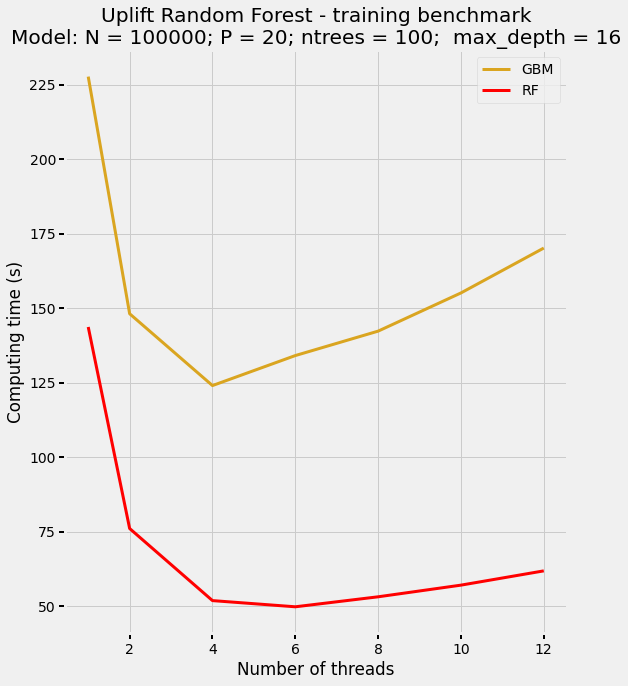

In [11]:
plot_result(gbm_time8, rf_time8)

### Bigger sample_size

In [12]:
N = 100000
P = 20
max_depth = 20
max_depths.append(max_depth)

df, x_names, treatment_column, response_column = syntetic_data(N, P)

In [13]:
gbm_time9, rf_time9 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptrfe3ot1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptrfe3ot1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptrfe3ot1\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,6 hours and 5 minutes
H2O_cluster_name:,H2O_from_python_potte_cv99x6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 306.4631361961365s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 74.76763844490051s
H2O session _sid_b41d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1rcnfsch
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1rcnfsch\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1rcnfsch\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,6 hours and 12 minutes
H2O_cluster_name:,H2O_from_python_potte_1adwp6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 299.5242097377777s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 74.95268368721008s
H2O session _sid_b278 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpspdbpdre
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpspdbpdre\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpspdbpdre\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,6 hours and 19 minutes
H2O_cluster_name:,H2O_from_python_potte_dtf8bs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 303.8270924091339s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 74.86828565597534s
H2O session _sid_a891 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzesk1ix6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzesk1ix6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzesk1ix6\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,6 hours and 26 minutes
H2O_cluster_name:,H2O_from_python_potte_j3zkae
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 306.3939862251282s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 74.52915143966675s
H2O session _sid_b5f5 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpb7ouqyp6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpb7ouqyp6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpb7ouqyp6\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,6 hours and 32 minutes
H2O_cluster_name:,H2O_from_python_potte_kzd5mm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 298.9197189807892s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 74.5050048828125s
H2O session _sid_9b69 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9hgb3cht
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9hgb3cht\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9hgb3cht\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,6 hours and 39 minutes
H2O_cluster_name:,H2O_from_python_potte_iqebxn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 302.3993878364563s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 74.54905438423157s
H2O session _sid_9783 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvujr5e_6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvujr5e_6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvujr5e_6\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,6 hours and 46 minutes
H2O_cluster_name:,H2O_from_python_potte_pwf8yn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 302.0952682495117s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 73.73463296890259s
H2O session _sid_a551 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7eozhux8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7eozhux8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7eozhux8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,6 hours and 52 minutes
H2O_cluster_name:,H2O_from_python_potte_02vipk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 296.73227548599243s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 76.03911876678467s
H2O session _sid_9ff4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmrcf23t6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmrcf23t6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmrcf23t6\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,6 hours and 59 minutes
H2O_cluster_name:,H2O_from_python_potte_fprg9u
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 301.5071258544922s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 74.47966861724854s
H2O session _sid_9811 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppyu4p5yj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppyu4p5yj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppyu4p5yj\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,7 hours and 5 minutes
H2O_cluster_name:,H2O_from_python_potte_nl24lg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 300.8129074573517s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 74.67404866218567s
H2O session _sid_8c16 closed.
Uplift 301.867510843277s
RF 74.70992875099182s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdznnc67b
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdznnc67b\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdznnc67b\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,7 hours and 12 minutes
H2O_cluster_name:,H2O_from_python_potte_a0fwb9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 278.9850957393646s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 69.35651683807373s
H2O session _sid_8250 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp95flda7i
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp95flda7i\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp95flda7i\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,7 hours and 18 minutes
H2O_cluster_name:,H2O_from_python_potte_ejktm3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 273.83350896835327s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 68.97378730773926s
H2O session _sid_a13e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8c95qxzq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8c95qxzq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8c95qxzq\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,7 hours and 24 minutes
H2O_cluster_name:,H2O_from_python_potte_gwt94u
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 279.12056279182434s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 68.96678686141968s
H2O session _sid_8c4d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxmi096w4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxmi096w4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxmi096w4\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,7 hours and 31 minutes
H2O_cluster_name:,H2O_from_python_potte_mhay6v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 272.8086519241333s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 68.66558122634888s
H2O session _sid_adb9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpemw7msc_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpemw7msc_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpemw7msc_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,7 hours and 37 minutes
H2O_cluster_name:,H2O_from_python_potte_9ygsvd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 278.04041504859924s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 69.17013216018677s
H2O session _sid_9b40 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsapu810v
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsapu810v\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpsapu810v\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,7 hours and 43 minutes
H2O_cluster_name:,H2O_from_python_potte_9u41o7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 276.92538714408875s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 68.77626180648804s
H2O session _sid_9414 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpj82119eg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpj82119eg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpj82119eg\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,7 hours and 49 minutes
H2O_cluster_name:,H2O_from_python_potte_43srno
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 274.83005595207214s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 68.48236441612244s
H2O session _sid_92cb closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnpfjx188
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnpfjx188\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnpfjx188\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,7 hours and 55 minutes
H2O_cluster_name:,H2O_from_python_potte_ia2c2c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 277.2552969455719s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 68.9043276309967s
H2O session _sid_b8b5 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqhgee_e8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqhgee_e8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqhgee_e8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 1 minute
H2O_cluster_name:,H2O_from_python_potte_nhgfcc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 279.8201289176941s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 68.86812472343445s
H2O session _sid_8fab closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp75k1mwbk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp75k1mwbk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp75k1mwbk\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 8 minutes
H2O_cluster_name:,H2O_from_python_potte_nd3mim
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 273.7451858520508s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 68.79715418815613s
H2O session _sid_bda8 closed.
Uplift 276.53642892837524s
RF 68.8961037158966s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_2ldkkzm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_2ldkkzm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_2ldkkzm\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 14 minutes
H2O_cluster_name:,H2O_from_python_potte_tuz6in
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 253.36586737632751s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 65.09088730812073s
H2O session _sid_adb1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpl6bgu4fj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpl6bgu4fj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpl6bgu4fj\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 19 minutes
H2O_cluster_name:,H2O_from_python_potte_5b1eq7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 252.27626252174377s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.69582653045654s
H2O session _sid_be87 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpss11gu01
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpss11gu01\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpss11gu01\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 25 minutes
H2O_cluster_name:,H2O_from_python_potte_965bhs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 251.97849535942078s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 63.69972205162048s
H2O session _sid_a558 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpur1absp6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpur1absp6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpur1absp6\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 31 minutes
H2O_cluster_name:,H2O_from_python_potte_2ujyti
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 253.65959525108337s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.98385500907898s
H2O session _sid_9b31 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpd5h83_u9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpd5h83_u9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpd5h83_u9\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 36 minutes
H2O_cluster_name:,H2O_from_python_potte_84vci1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 251.47196102142334s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 65.70140552520752s
H2O session _sid_8517 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfox8zl7v
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfox8zl7v\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfox8zl7v\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 42 minutes
H2O_cluster_name:,H2O_from_python_potte_kkhnjg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 250.20095777511597s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 65.58206129074097s
H2O session _sid_a6d3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpenj8oyti
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpenj8oyti\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpenj8oyti\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 48 minutes
H2O_cluster_name:,H2O_from_python_potte_s72m6l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 254.60768246650696s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 65.416748046875s
H2O session _sid_b13b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9jmqqk6l
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9jmqqk6l\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9jmqqk6l\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 54 minutes
H2O_cluster_name:,H2O_from_python_potte_x0nrux
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 248.59122395515442s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 66.16764616966248s
H2O session _sid_b05d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplgufzva8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplgufzva8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplgufzva8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 59 minutes
H2O_cluster_name:,H2O_from_python_potte_nmbzlp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 249.7436625957489s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.73468589782715s
H2O session _sid_b0d8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmph7kok2m_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmph7kok2m_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmph7kok2m_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 5 minutes
H2O_cluster_name:,H2O_from_python_potte_o3ykvm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 249.7824478149414s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 65.8013105392456s
H2O session _sid_a068 closed.
Uplift 251.56781561374663s
RF 65.18741483688355s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpu6kxcoc8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpu6kxcoc8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpu6kxcoc8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 10 minutes
H2O_cluster_name:,H2O_from_python_potte_ebtw2n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 239.08814668655396s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 61.2816960811615s
H2O session _sid_bd1e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp64eep1pa
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp64eep1pa\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp64eep1pa\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 16 minutes
H2O_cluster_name:,H2O_from_python_potte_0cf40c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 235.93107414245605s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 61.337170362472534s
H2O session _sid_b932 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpto4zm5rg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpto4zm5rg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpto4zm5rg\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 21 minutes
H2O_cluster_name:,H2O_from_python_potte_jnq0je
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 237.38964200019836s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 61.14942741394043s
H2O session _sid_8b89 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpaw8i2i94
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpaw8i2i94\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpaw8i2i94\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 27 minutes
H2O_cluster_name:,H2O_from_python_potte_g9uda3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 239.4714024066925s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 60.91784405708313s
H2O session _sid_931c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmlthsc4c
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmlthsc4c\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmlthsc4c\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 32 minutes
H2O_cluster_name:,H2O_from_python_potte_61p6f3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 235.79538440704346s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 61.065956592559814s
H2O session _sid_84f8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpk6sxv1vw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpk6sxv1vw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpk6sxv1vw\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 37 minutes
H2O_cluster_name:,H2O_from_python_potte_pz33dj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 237.25401163101196s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 61.924532413482666s
H2O session _sid_9dd1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpn11gqpt3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpn11gqpt3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpn11gqpt3\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 43 minutes
H2O_cluster_name:,H2O_from_python_potte_zsn37n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 237.44090104103088s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 59.98561239242554s
H2O session _sid_a2e4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpp1l4doo8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpp1l4doo8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpp1l4doo8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 48 minutes
H2O_cluster_name:,H2O_from_python_potte_kqhntt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 236.87986660003662s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 61.062119245529175s
H2O session _sid_bcc4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpilp66unb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpilp66unb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpilp66unb\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 53 minutes
H2O_cluster_name:,H2O_from_python_potte_19ydsj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 237.42630338668823s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 60.96646332740784s
H2O session _sid_b1ea closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpe6n00nn9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpe6n00nn9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpe6n00nn9\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 59 minutes
H2O_cluster_name:,H2O_from_python_potte_ejx7vw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 237.08357167243958s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 61.10526251792908s
H2O session _sid_8998 closed.
Uplift 237.37603039741515s
RF 61.07960844039917s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpaqxkm0uj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpaqxkm0uj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpaqxkm0uj\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server a

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 hours and 4 minutes
H2O_cluster_name:,H2O_from_python_potte_jfu4g2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 216.39441752433777s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 63.144850730895996s
H2O session _sid_a4e6 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpb2377oo7
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpb2377oo7\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpb2377oo7\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 hours and 9 minutes
H2O_cluster_name:,H2O_from_python_potte_b0uwv1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 217.44513130187988s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 62.939919233322144s
H2O session _sid_bc7a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_e0csogw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_e0csogw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_e0csogw\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 hours and 14 minutes
H2O_cluster_name:,H2O_from_python_potte_0winiv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 216.30445909500122s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 63.15326404571533s
H2O session _sid_a450 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpp5rrrkjn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpp5rrrkjn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpp5rrrkjn\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 hours and 19 minutes
H2O_cluster_name:,H2O_from_python_potte_1atjuf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 213.67678475379944s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 63.1697781085968s
H2O session _sid_97f1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1uyt9ja0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1uyt9ja0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1uyt9ja0\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 hours and 24 minutes
H2O_cluster_name:,H2O_from_python_potte_bykhl1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 216.68587684631348s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 63.11490797996521s
H2O session _sid_a219 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprzw8vfuh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprzw8vfuh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprzw8vfuh\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 hours and 29 minutes
H2O_cluster_name:,H2O_from_python_potte_g3uivq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 214.47238421440125s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 63.2716326713562s
H2O session _sid_8265 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp16z5ea5i
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp16z5ea5i\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp16z5ea5i\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 hours and 34 minutes
H2O_cluster_name:,H2O_from_python_potte_2rjzmc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 216.74934887886047s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 63.253599643707275s
H2O session _sid_9da1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp89oeik25
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp89oeik25\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp89oeik25\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 hours and 40 minutes
H2O_cluster_name:,H2O_from_python_potte_1jklcr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 217.28938627243042s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 63.02235198020935s
H2O session _sid_9ac1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7qtch19q
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7qtch19q\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7qtch19q\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 hours and 45 minutes
H2O_cluster_name:,H2O_from_python_potte_bedlzi
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 217.02150678634644s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 63.15196633338928s
H2O session _sid_af59 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp86cjwf26
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp86cjwf26\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp86cjwf26\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 hours and 50 minutes
H2O_cluster_name:,H2O_from_python_potte_elzohr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 215.57205724716187s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 63.107372760772705s
H2O session _sid_bf8b closed.
Uplift 216.16113529205322s
RF 63.13296434879303s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_grcgacr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_grcgacr\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_grcgacr\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 hours and 55 minutes
H2O_cluster_name:,H2O_from_python_potte_eis6e2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 253.9132001399994s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 93.35217571258545s
H2O session _sid_82c1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmn5t6gxo
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmn5t6gxo\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmn5t6gxo\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,11 hours and 1 minute
H2O_cluster_name:,H2O_from_python_potte_ik69j8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 251.28525519371033s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 93.22674369812012s
H2O session _sid_9f8f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjo43bl83
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjo43bl83\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjo43bl83\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,11 hours and 7 minutes
H2O_cluster_name:,H2O_from_python_potte_ff039i
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 253.3907504081726s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 93.41149497032166s
H2O session _sid_be24 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnr3bloz4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnr3bloz4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnr3bloz4\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,11 hours and 13 minutes
H2O_cluster_name:,H2O_from_python_potte_b9ub87
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 248.6320402622223s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 92.67422437667847s
H2O session _sid_a4c3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpe7xt9kx_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpe7xt9kx_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpe7xt9kx_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,11 hours and 19 minutes
H2O_cluster_name:,H2O_from_python_potte_fephxa
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 253.74621057510376s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 92.48846292495728s
H2O session _sid_b882 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpc4d1ns8g
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpc4d1ns8g\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpc4d1ns8g\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,11 hours and 26 minutes
H2O_cluster_name:,H2O_from_python_potte_sskbu9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 252.298832654953s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 92.71989488601685s
H2O session _sid_af03 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp51yj5e08
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp51yj5e08\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp51yj5e08\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,11 hours and 32 minutes
H2O_cluster_name:,H2O_from_python_potte_5s2xvu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 251.388347864151s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 92.26239919662476s
H2O session _sid_a1d2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpuza6i0tg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpuza6i0tg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpuza6i0tg\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,11 hours and 38 minutes
H2O_cluster_name:,H2O_from_python_potte_8jl9oq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 249.12874674797058s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 91.02387809753418s
H2O session _sid_af4a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpl2n5i8al
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpl2n5i8al\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpl2n5i8al\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,11 hours and 44 minutes
H2O_cluster_name:,H2O_from_python_potte_ugv2fp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 245.42186379432678s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 91.1449990272522s
H2O session _sid_9e36 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdgy13pp0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdgy13pp0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdgy13pp0\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,11 hours and 50 minutes
H2O_cluster_name:,H2O_from_python_potte_28i5wq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 251.4216606616974s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 93.82598733901978s
H2O session _sid_b7ea closed.
Uplift 251.0626908302307s
RF 92.61302602291107s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptfo4yb0z
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptfo4yb0z\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptfo4yb0z\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,11 hours and 56 minutes
H2O_cluster_name:,H2O_from_python_potte_mzrig7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 368.62794184684753s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 170.29376411437988s
H2O session _sid_a93a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvw74n2u2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvw74n2u2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvw74n2u2\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,12 hours and 5 minutes
H2O_cluster_name:,H2O_from_python_potte_mt0jey
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 368.6381905078888s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 172.12946391105652s
H2O session _sid_9dde closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp41d7ez_l
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp41d7ez_l\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp41d7ez_l\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,12 hours and 15 minutes
H2O_cluster_name:,H2O_from_python_potte_go1ov3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 381.9001636505127s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 174.61882042884827s
H2O session _sid_bbdf closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp44irlvv6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp44irlvv6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp44irlvv6\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,12 hours and 24 minutes
H2O_cluster_name:,H2O_from_python_potte_rscmn3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 384.198548078537s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 174.24968075752258s
H2O session _sid_81bd closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpju3ku5_e
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpju3ku5_e\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpju3ku5_e\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,12 hours and 34 minutes
H2O_cluster_name:,H2O_from_python_potte_hds0ka
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 366.54072856903076s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 171.8099241256714s
H2O session _sid_8612 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpamr4w1n6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpamr4w1n6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpamr4w1n6\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,12 hours and 44 minutes
H2O_cluster_name:,H2O_from_python_potte_878hqm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 384.2400014400482s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 175.26138186454773s
H2O session _sid_8217 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpydkfwgfa
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpydkfwgfa\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpydkfwgfa\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,12 hours and 53 minutes
H2O_cluster_name:,H2O_from_python_potte_g1jrn9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 381.4668924808502s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 174.76674699783325s
H2O session _sid_a767 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphwrd_iv3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphwrd_iv3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphwrd_iv3\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 3 minutes
H2O_cluster_name:,H2O_from_python_potte_8akdki
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 384.08794355392456s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 173.91909170150757s
H2O session _sid_87a1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpan6629lb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpan6629lb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpan6629lb\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 13 minutes
H2O_cluster_name:,H2O_from_python_potte_p0tn6z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 382.86604285240173s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 174.0468225479126s
H2O session _sid_b59a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpr73r6klq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpr73r6klq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpr73r6klq\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 22 minutes
H2O_cluster_name:,H2O_from_python_potte_17ba60
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 384.35275626182556s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 175.08358001708984s
H2O session _sid_918c closed.
Uplift 378.6919209241867s
RF 173.61792764663696s
12 - Uplift = 301.867510843277, RF = 74.70992875099182
10 - Uplift = 276.53642892837524, RF = 68.8961037158966
8 - Uplift = 251.56781561374663, RF = 65.18741483688355
6 - Uplift = 237.37603039741515, RF = 61.07960844039917
4 - Uplift = 216.16113529205322, RF = 63.13296434879303
2 - Uplift = 251.0626908302307, RF = 92.61302602291107
1 - Uplift = 378.6919209241867, RF = 173.61792764663696


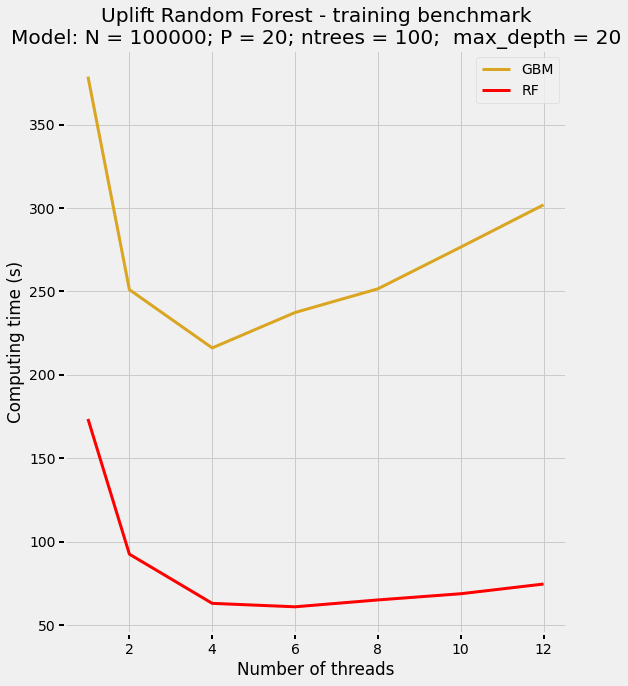

In [14]:
plot_result(gbm_time9, rf_time9)

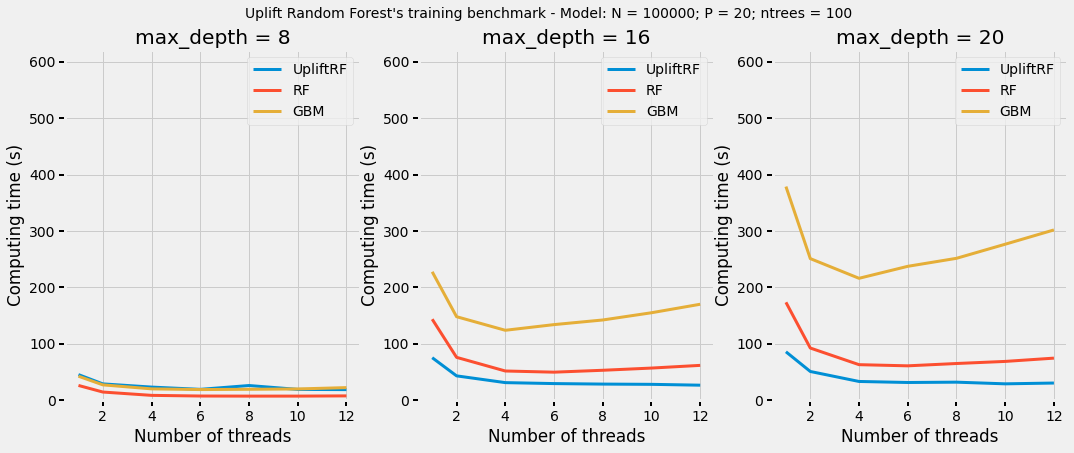

In [15]:
all_predict_uplift = [{12: 18.93900990486145, 10: 19.30182449022929, 8: 26.17604915301005, 6: 19.397459427515667, 4: 23.40986116727193, 2: 29.07012955347697, 1: 45.50412805875143}, {12: 26.778035481770832, 10: 28.275341510772705, 8: 28.730897188186646, 6: 29.619952996571858, 4: 31.316644271214802, 2: 43.301218112309776, 1: 75.48034636179607}, {12: 30.582640409469604, 10: 29.177462100982666, 8: 32.13025641441345, 6: 31.55892292658488, 4: 33.371968825658165, 2: 51.07243879636129, 1: 85.96301698684692}]
all_predict_gbm = [gbm_time7, gbm_time8, gbm_time9]
all_predict_rf = [rf_time7, rf_time8, rf_time9]

fig=plt.figure(figsize=(16,6))
fig.suptitle(f"Uplift Random Forest's training benchmark - Model: N = {N}; P = {P}; ntrees = {ntrees}", fontsize=14)

for uplift_time, rf_time, gbm_time, i in zip(all_predict_uplift, all_predict_rf, all_predict_gbm, range(1, len(max_depths) + 1)):
    fig.add_subplot(130 + i)
    data = {"x":[], "y": [], "label":[]}
    for label, coord in uplift_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"UpliftRF", linewidth=3)

    data = {"x":[], "y": [], "label":[]}
    for label, coord in rf_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"RF", linewidth=3)    
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in gbm_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"GBM", linewidth=3)
    
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.ylim(0, 620)
    plt.legend() 
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"max_depth = {max_depths[i - 1]}")

plt.savefig(f"h2o-train-perf{random.random()}.png", bbox_inches='tight', pad_inches=.05)
plt.show()

In [16]:
print(all_predict_uplift)

[{12: 18.93900990486145, 10: 19.30182449022929, 8: 26.17604915301005, 6: 19.397459427515667, 4: 23.40986116727193, 2: 29.07012955347697, 1: 45.50412805875143}, {12: 26.778035481770832, 10: 28.275341510772705, 8: 28.730897188186646, 6: 29.619952996571858, 4: 31.316644271214802, 2: 43.301218112309776, 1: 75.48034636179607}, {12: 30.582640409469604, 10: 29.177462100982666, 8: 32.13025641441345, 6: 31.55892292658488, 4: 33.371968825658165, 2: 51.07243879636129, 1: 85.96301698684692}]


In [17]:
print(all_predict_gbm)

[{12: 22.480031037330626, 10: 20.100569820404054, 8: 19.50397570133209, 6: 19.02869620323181, 4: 20.260752630233764, 2: 27.356335163116455, 1: 42.66778080463409}, {12: 170.18061714172364, 10: 155.1232393026352, 8: 142.310054397583, 6: 134.1138013601303, 4: 124.05112998485565, 2: 148.1445460319519, 1: 227.6855852842331}, {12: 301.867510843277, 10: 276.53642892837524, 8: 251.56781561374663, 6: 237.37603039741515, 4: 216.16113529205322, 2: 251.0626908302307, 1: 378.6919209241867}]


In [18]:
print(all_predict_rf)

[{12: 7.82650899887085, 10: 7.432150673866272, 8: 7.403486657142639, 6: 7.591434931755066, 4: 8.750728392601014, 2: 14.63959093093872, 1: 26.316685152053832}, {12: 61.89431653022766, 10: 57.10806846618652, 8: 53.19700427055359, 6: 49.84526455402374, 4: 51.92042896747589, 2: 76.1032977104187, 1: 143.70539066791534}, {12: 74.70992875099182, 10: 68.8961037158966, 8: 65.18741483688355, 6: 61.07960844039917, 4: 63.13296434879303, 2: 92.61302602291107, 1: 173.61792764663696}]


In [19]:
nbinss = []

In [20]:
N = 100000
P = 20
max_depth = 16
nbins=20
nbinss.append(nbins)

df, x_names, treatment_column, response_column = syntetic_data(N, P)

In [21]:
gbm_time0, rf_time0 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2od6_a__
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2od6_a__\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2od6_a__\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 32 minutes
H2O_cluster_name:,H2O_from_python_potte_yjnzv6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 31.402902126312256s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 16.429463863372803s
H2O session _sid_bbda closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpj2zr7mbj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpj2zr7mbj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpj2zr7mbj\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 33 minutes
H2O_cluster_name:,H2O_from_python_potte_uoal64
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 30.706032752990723s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 16.591179132461548s
H2O session _sid_b8cf closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8w1e2pn6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8w1e2pn6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8w1e2pn6\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 34 minutes
H2O_cluster_name:,H2O_from_python_potte_pfr3kp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 31.597729444503784s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.055755138397217s
H2O session _sid_b8c2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmple8s8uru
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmple8s8uru\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmple8s8uru\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 36 minutes
H2O_cluster_name:,H2O_from_python_potte_op16mk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 30.961434602737427s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 16.798936128616333s
H2O session _sid_b7d8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpt8sbe0us
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpt8sbe0us\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpt8sbe0us\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 37 minutes
H2O_cluster_name:,H2O_from_python_potte_ourmzu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 30.849478006362915s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.001371145248413s
H2O session _sid_a453 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpalrwlfs9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpalrwlfs9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpalrwlfs9\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 38 minutes
H2O_cluster_name:,H2O_from_python_potte_yem5o6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 30.937469959259033s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.41454768180847s
H2O session _sid_a738 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfgl411u9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfgl411u9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfgl411u9\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 39 minutes
H2O_cluster_name:,H2O_from_python_potte_nxehet
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 30.837640285491943s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.54480266571045s
H2O session _sid_84ed closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcpzgchaa
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcpzgchaa\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcpzgchaa\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 40 minutes
H2O_cluster_name:,H2O_from_python_potte_x5garz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 31.785077810287476s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.34779930114746s
H2O session _sid_bbd2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptjwixd78
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptjwixd78\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptjwixd78\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 42 minutes
H2O_cluster_name:,H2O_from_python_potte_dfqlqc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 30.78742790222168s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 16.84017038345337s
H2O session _sid_bf99 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdz5kwjz5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdz5kwjz5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdz5kwjz5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 43 minutes
H2O_cluster_name:,H2O_from_python_potte_u9741a
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 30.588831663131714s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 16.668262004852295s
H2O session _sid_b9cd closed.
Uplift 31.045402455329896s
RF 16.969228744506836s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5nc_tj8v
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5nc_tj8v\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5nc_tj8v\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 44 minutes
H2O_cluster_name:,H2O_from_python_potte_tu5maj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 29.672186136245728s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 16.99039101600647s
H2O session _sid_a379 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphty8kzwr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphty8kzwr\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphty8kzwr\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 45 minutes
H2O_cluster_name:,H2O_from_python_potte_vx3aev
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 29.86566948890686s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.145217418670654s
H2O session _sid_89bf closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp10lp7799
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp10lp7799\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp10lp7799\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 46 minutes
H2O_cluster_name:,H2O_from_python_potte_0dc4g2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 29.629316806793213s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 16.502620935440063s
H2O session _sid_b1b5 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqcvebwm7
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqcvebwm7\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqcvebwm7\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 48 minutes
H2O_cluster_name:,H2O_from_python_potte_zske2o
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 30.19036555290222s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.202516555786133s
H2O session _sid_b2e9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7kb30y5z
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7kb30y5z\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7kb30y5z\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 49 minutes
H2O_cluster_name:,H2O_from_python_potte_m04zs3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 29.863024473190308s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.17999815940857s
H2O session _sid_bac0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6bo154sy
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6bo154sy\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6bo154sy\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 50 minutes
H2O_cluster_name:,H2O_from_python_potte_lfl4ed
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 30.302573680877686s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.21784281730652s
H2O session _sid_824d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9slvk1ny
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9slvk1ny\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9slvk1ny\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 51 minutes
H2O_cluster_name:,H2O_from_python_potte_8r770d
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 30.468540906906128s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 16.98401117324829s
H2O session _sid_a216 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbmtwl9qt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbmtwl9qt\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbmtwl9qt\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 52 minutes
H2O_cluster_name:,H2O_from_python_potte_cb3yiq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 30.31977343559265s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 16.946078538894653s
H2O session _sid_b2c7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphm901nh0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphm901nh0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphm901nh0\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 54 minutes
H2O_cluster_name:,H2O_from_python_potte_v4m0jw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 30.264405012130737s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 16.889694929122925s
H2O session _sid_83e7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxvwdkj98
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxvwdkj98\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxvwdkj98\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 55 minutes
H2O_cluster_name:,H2O_from_python_potte_0r5aa5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 29.45539617538452s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 16.292108297348022s
H2O session _sid_8e5b closed.
Uplift 30.003125166893007s
RF 16.93504798412323s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpx68blvjk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpx68blvjk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpx68blvjk\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server a

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 56 minutes
H2O_cluster_name:,H2O_from_python_potte_spa8n1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 28.984986066818237s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 16.879266262054443s
H2O session _sid_984e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptm3zc7ho
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptm3zc7ho\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptm3zc7ho\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 57 minutes
H2O_cluster_name:,H2O_from_python_potte_v20vic
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 29.432438373565674s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 16.97018265724182s
H2O session _sid_a92b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkqqw0wra
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkqqw0wra\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkqqw0wra\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 58 minutes
H2O_cluster_name:,H2O_from_python_potte_8fomeh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 30.35388946533203s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.309727668762207s
H2O session _sid_8110 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpprpl82y6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpprpl82y6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpprpl82y6\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 59 minutes
H2O_cluster_name:,H2O_from_python_potte_58v97u
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 29.15169405937195s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 16.93839192390442s
H2O session _sid_b69e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppwm0qqwy
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppwm0qqwy\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppwm0qqwy\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 1 minute
H2O_cluster_name:,H2O_from_python_potte_u2xey7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 29.389589309692383s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.155455350875854s
H2O session _sid_979a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp26jaaa2h
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp26jaaa2h\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp26jaaa2h\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 2 minutes
H2O_cluster_name:,H2O_from_python_potte_fm2oo5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 29.937638521194458s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 16.922834873199463s
H2O session _sid_ab6f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdstuejq7
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdstuejq7\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdstuejq7\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 3 minutes
H2O_cluster_name:,H2O_from_python_potte_fus7n0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 29.0571072101593s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 16.95287275314331s
H2O session _sid_885d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmps8iezrvq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmps8iezrvq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmps8iezrvq\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 4 minutes
H2O_cluster_name:,H2O_from_python_potte_to4ua9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 29.85805892944336s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.085094213485718s
H2O session _sid_8ab3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8lfsrgo9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8lfsrgo9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8lfsrgo9\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 5 minutes
H2O_cluster_name:,H2O_from_python_potte_gwg5wd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 29.26603102684021s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 16.964102029800415s
H2O session _sid_ba15 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpn19cs5c7
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpn19cs5c7\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpn19cs5c7\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 6 minutes
H2O_cluster_name:,H2O_from_python_potte_zm41ho
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 29.16581106185913s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 16.814184427261353s
H2O session _sid_90b4 closed.
Uplift 29.459724402427675s
RF 16.9992112159729s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4lr0ckhs
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4lr0ckhs\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4lr0ckhs\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 8 minutes
H2O_cluster_name:,H2O_from_python_potte_8jz5e2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 30.111081838607788s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.873234510421753s
H2O session _sid_a62d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpn68kxtv1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpn68kxtv1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpn68kxtv1\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 9 minutes
H2O_cluster_name:,H2O_from_python_potte_1b8k7x
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 29.28413200378418s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.452643632888794s
H2O session _sid_82c9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4taec4sl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4taec4sl\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4taec4sl\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 10 minutes
H2O_cluster_name:,H2O_from_python_potte_567lcs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 29.460779428482056s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.02226209640503s
H2O session _sid_8fc9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfbquuph7
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfbquuph7\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfbquuph7\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 11 minutes
H2O_cluster_name:,H2O_from_python_potte_hq4p5p
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 29.402642488479614s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.978724002838135s
H2O session _sid_9d21 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpohd1rx7t
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpohd1rx7t\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpohd1rx7t\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 12 minutes
H2O_cluster_name:,H2O_from_python_potte_gdb2ma
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 29.34014320373535s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.038339853286743s
H2O session _sid_9be3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0weupy_o
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0weupy_o\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0weupy_o\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 14 minutes
H2O_cluster_name:,H2O_from_python_potte_1nrx26
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 30.858170986175537s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.12043571472168s
H2O session _sid_9c86 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0nhm5_le
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0nhm5_le\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0nhm5_le\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 15 minutes
H2O_cluster_name:,H2O_from_python_potte_7khbsx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 29.44649910926819s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.083735704421997s
H2O session _sid_85b1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwdu5vuch
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwdu5vuch\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwdu5vuch\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 16 minutes
H2O_cluster_name:,H2O_from_python_potte_pv61ie
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 29.39512038230896s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.088566303253174s
H2O session _sid_bb72 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6tffxn4n
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6tffxn4n\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6tffxn4n\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 17 minutes
H2O_cluster_name:,H2O_from_python_potte_nkwt5g
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 29.74513554573059s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.90862202644348s
H2O session _sid_b718 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3w5lvot8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3w5lvot8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3w5lvot8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 18 minutes
H2O_cluster_name:,H2O_from_python_potte_srgs0z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 29.144275665283203s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.346336603164673s
H2O session _sid_b700 closed.
Uplift 29.618798065185548s
RF 17.891290044784547s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0wwf_in3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0wwf_in3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0wwf_in3\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 20 minutes
H2O_cluster_name:,H2O_from_python_potte_jafptt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 32.45150065422058s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.59079146385193s
H2O session _sid_b6f4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0skjxaxa
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0skjxaxa\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0skjxaxa\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 21 minutes
H2O_cluster_name:,H2O_from_python_potte_x1s84z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 31.768621683120728s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 20.756273984909058s
H2O session _sid_bbad closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6ymc1bwr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6ymc1bwr\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6ymc1bwr\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 22 minutes
H2O_cluster_name:,H2O_from_python_potte_ou6zdd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 31.645035982131958s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.25619077682495s
H2O session _sid_b75d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4l_ml_fp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4l_ml_fp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4l_ml_fp\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 23 minutes
H2O_cluster_name:,H2O_from_python_potte_37w6ff
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 31.53596830368042s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 20.695154905319214s
H2O session _sid_b961 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpersmmrbh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpersmmrbh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpersmmrbh\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 25 minutes
H2O_cluster_name:,H2O_from_python_potte_7ahezv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 31.94032597541809s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.268502712249756s
H2O session _sid_9b46 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpc8vvng5w
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpc8vvng5w\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpc8vvng5w\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 26 minutes
H2O_cluster_name:,H2O_from_python_potte_ks46bf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 31.655693292617798s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.477577447891235s
H2O session _sid_bccc closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpajweupyt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpajweupyt\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpajweupyt\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 27 minutes
H2O_cluster_name:,H2O_from_python_potte_1advk3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 32.96866488456726s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 20.77391505241394s
H2O session _sid_861a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcaxtyt9g
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcaxtyt9g\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcaxtyt9g\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 28 minutes
H2O_cluster_name:,H2O_from_python_potte_6sxp7l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 32.47065281867981s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.853774547576904s
H2O session _sid_bc44 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9fp0x7xd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9fp0x7xd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9fp0x7xd\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 30 minutes
H2O_cluster_name:,H2O_from_python_potte_hhjj0y
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 31.70917320251465s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.596676349639893s
H2O session _sid_a9de closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjn3kx3uf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjn3kx3uf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjn3kx3uf\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 31 minutes
H2O_cluster_name:,H2O_from_python_potte_27fi06
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 32.51187777519226s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.484103202819824s
H2O session _sid_a43e closed.
Uplift 32.065751457214354s
RF 21.27529604434967s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5f9cu9jg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5f9cu9jg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5f9cu9jg\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server a

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 32 minutes
H2O_cluster_name:,H2O_from_python_potte_81gfua
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.44843888282776s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.187243938446045s
H2O session _sid_93b3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3bd4ytwr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3bd4ytwr\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3bd4ytwr\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 34 minutes
H2O_cluster_name:,H2O_from_python_potte_dlxgd3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.28727197647095s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.91117739677429s
H2O session _sid_9605 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpquqktjd0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpquqktjd0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpquqktjd0\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 36 minutes
H2O_cluster_name:,H2O_from_python_potte_dj7ve1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.15486001968384s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 33.99623250961304s
H2O session _sid_9b35 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpx9msj3a4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpx9msj3a4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpx9msj3a4\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 38 minutes
H2O_cluster_name:,H2O_from_python_potte_a8fave
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.77784729003906s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.103641510009766s
H2O session _sid_8e78 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpohnvq2ua
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpohnvq2ua\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpohnvq2ua\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 39 minutes
H2O_cluster_name:,H2O_from_python_potte_fk1qt1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.97166156768799s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.9975471496582s
H2O session _sid_834d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6lydx_kn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6lydx_kn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6lydx_kn\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 41 minutes
H2O_cluster_name:,H2O_from_python_potte_xuixgy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.08571147918701s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.62187695503235s
H2O session _sid_ae0c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpe8e5edig
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpe8e5edig\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpe8e5edig\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 43 minutes
H2O_cluster_name:,H2O_from_python_potte_apg8y7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.07861065864563s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.024802684783936s
H2O session _sid_a66d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpa1fjhx38
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpa1fjhx38\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpa1fjhx38\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 44 minutes
H2O_cluster_name:,H2O_from_python_potte_ii4jpm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.899465560913086s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.11975049972534s
H2O session _sid_bc15 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5ujw_ggs
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5ujw_ggs\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5ujw_ggs\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 46 minutes
H2O_cluster_name:,H2O_from_python_potte_kimbmu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.875412940979004s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.527700662612915s
H2O session _sid_9d34 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpuduqqint
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpuduqqint\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpuduqqint\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 48 minutes
H2O_cluster_name:,H2O_from_python_potte_4xht2c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.780006408691406s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 33.98903155326843s
H2O session _sid_b189 closed.
Uplift 45.13592867851257s
RF 34.54790048599243s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvr6e4gq7
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvr6e4gq7\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvr6e4gq7\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 50 minutes
H2O_cluster_name:,H2O_from_python_potte_t5lf2q
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 71.46458911895752s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 63.89029359817505s
H2O session _sid_80cd closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpm50wk7tw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpm50wk7tw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpm50wk7tw\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 52 minutes
H2O_cluster_name:,H2O_from_python_potte_de8abn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 71.51927375793457s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.01382827758789s
H2O session _sid_90b9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqvrxq0hx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqvrxq0hx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqvrxq0hx\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 55 minutes
H2O_cluster_name:,H2O_from_python_potte_s1kx06
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 71.77746415138245s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 65.3367428779602s
H2O session _sid_a853 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpullhswkx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpullhswkx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpullhswkx\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 58 minutes
H2O_cluster_name:,H2O_from_python_potte_s2lty2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 71.73844814300537s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.38119125366211s
H2O session _sid_99b5 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptcrdnmu1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptcrdnmu1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptcrdnmu1\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,15 hours
H2O_cluster_name:,H2O_from_python_potte_848jyg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 71.47934484481812s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.70284867286682s
H2O session _sid_9479 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpf4dptd2n
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpf4dptd2n\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpf4dptd2n\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,15 hours and 3 minutes
H2O_cluster_name:,H2O_from_python_potte_8zw5p8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 71.75865530967712s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.11014080047607s
H2O session _sid_8fbc closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpeg8xk7fr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpeg8xk7fr\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpeg8xk7fr\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,15 hours and 6 minutes
H2O_cluster_name:,H2O_from_python_potte_ea73tl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 71.85294818878174s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.32031321525574s
H2O session _sid_87e8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkyr6ssnj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkyr6ssnj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkyr6ssnj\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,15 hours and 8 minutes
H2O_cluster_name:,H2O_from_python_potte_m5nw22
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 71.51637268066406s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 63.90510439872742s
H2O session _sid_8171 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1ado3yba
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1ado3yba\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1ado3yba\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,15 hours and 11 minutes
H2O_cluster_name:,H2O_from_python_potte_7fqgo1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 71.59029173851013s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.08497309684753s
H2O session _sid_9cb7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmper3_tqd0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmper3_tqd0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmper3_tqd0\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,15 hours and 14 minutes
H2O_cluster_name:,H2O_from_python_potte_urfjgh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 72.05412364006042s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.82499527931213s
H2O session _sid_90f8 closed.
Uplift 71.67515115737915s
RF 64.3570431470871s
12 - Uplift = 31.045402455329896, RF = 16.969228744506836
10 - Uplift = 30.003125166893007, RF = 16.93504798412323
8 - Uplift = 29.459724402427675, RF = 16.9992112159729
6 - Uplift = 29.618798065185548, RF = 17.891290044784547
4 - Uplift = 32.065751457214354, RF = 21.27529604434967
2 - Uplift = 45.13592867851257, RF = 34.54790048599243
1 - Uplift = 71.67515115737915, RF = 64.3570431470871


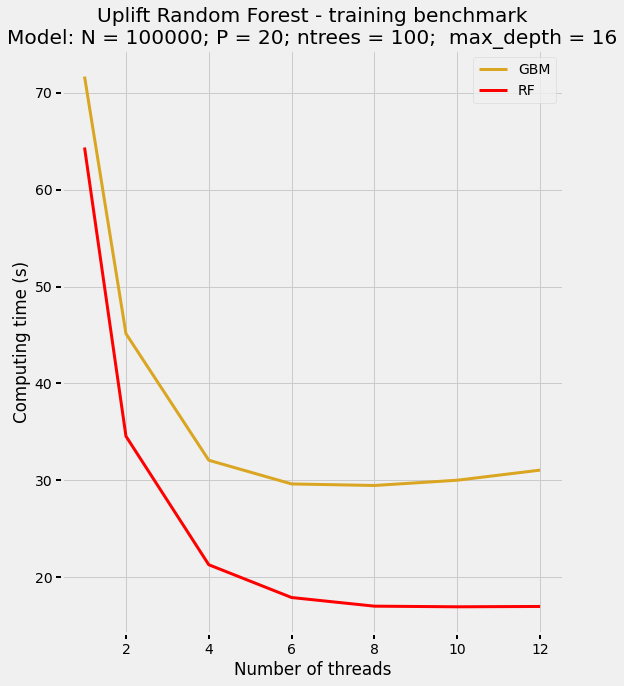

In [22]:
plot_result(gbm_time0, rf_time0)

In [23]:
N = 100000
P = 20
max_depth = 16
nbins=400
nbinss.append(nbins)

df, x_names, treatment_column, response_column = syntetic_data(N, P)

In [24]:
gbm_time1, rf_time1 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp73ruv1pb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp73ruv1pb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp73ruv1pb\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,15 hours and 16 minutes
H2O_cluster_name:,H2O_from_python_potte_j9fn70
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 88.10203123092651s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.89391088485718s
H2O session _sid_8b0e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp74fa0g7m
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp74fa0g7m\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp74fa0g7m\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,15 hours and 19 minutes
H2O_cluster_name:,H2O_from_python_potte_uirqv9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 90.35335302352905s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.77961277961731s
H2O session _sid_b614 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpc6tbkyf2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpc6tbkyf2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpc6tbkyf2\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,15 hours and 21 minutes
H2O_cluster_name:,H2O_from_python_potte_x7gl5n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 89.5324113368988s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.9630172252655s
H2O session _sid_849e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8zjixura
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8zjixura\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8zjixura\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,15 hours and 24 minutes
H2O_cluster_name:,H2O_from_python_potte_igk84v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 91.95584034919739s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.777541399002075s
H2O session _sid_be79 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphoqybo7o
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphoqybo7o\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphoqybo7o\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,15 hours and 26 minutes
H2O_cluster_name:,H2O_from_python_potte_00f9k0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 90.39254450798035s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.07576513290405s
H2O session _sid_89e5 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpigmhc6p8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpigmhc6p8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpigmhc6p8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,15 hours and 29 minutes
H2O_cluster_name:,H2O_from_python_potte_jol49s
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 90.44043564796448s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.73187255859375s
H2O session _sid_a37c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkrr6_0_v
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkrr6_0_v\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkrr6_0_v\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,15 hours and 31 minutes
H2O_cluster_name:,H2O_from_python_potte_r7jwjz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 88.05651021003723s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.58356261253357s
H2O session _sid_be95 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3e1i5hdi
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3e1i5hdi\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3e1i5hdi\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,15 hours and 34 minutes
H2O_cluster_name:,H2O_from_python_potte_r2nhbl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 87.02897572517395s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.832032680511475s
H2O session _sid_abe8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqm9y2z6h
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqm9y2z6h\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqm9y2z6h\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,15 hours and 36 minutes
H2O_cluster_name:,H2O_from_python_potte_eccooi
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 91.23413467407227s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.681904315948486s
H2O session _sid_b47e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpagc7dkyp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpagc7dkyp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpagc7dkyp\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,15 hours and 39 minutes
H2O_cluster_name:,H2O_from_python_potte_8lueqq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 91.03668189048767s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.6207594871521s
H2O session _sid_a1d4 closed.
Uplift 89.81329185962677s
RF 35.09399790763855s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpycfvzo3r
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpycfvzo3r\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpycfvzo3r\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,15 hours and 41 minutes
H2O_cluster_name:,H2O_from_python_potte_27vq5q
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 80.17255187034607s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 33.06480836868286s
H2O session _sid_9afd closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdczhfjrb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdczhfjrb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdczhfjrb\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,15 hours and 43 minutes
H2O_cluster_name:,H2O_from_python_potte_0jc87a
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 80.6242425441742s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 33.004308462142944s
H2O session _sid_97c4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpm8qc28nx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpm8qc28nx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpm8qc28nx\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,15 hours and 46 minutes
H2O_cluster_name:,H2O_from_python_potte_g4qxc6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 80.80436849594116s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 33.27119421958923s
H2O session _sid_95a1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpso1gc4lp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpso1gc4lp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpso1gc4lp\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,15 hours and 48 minutes
H2O_cluster_name:,H2O_from_python_potte_tvqpqj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 80.45006465911865s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 32.86414337158203s
H2O session _sid_9e3d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_atum1fx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_atum1fx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_atum1fx\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,15 hours and 50 minutes
H2O_cluster_name:,H2O_from_python_potte_mhu7x2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 80.77491903305054s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 33.12379312515259s
H2O session _sid_bff8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqr6j7sfk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqr6j7sfk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqr6j7sfk\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,15 hours and 53 minutes
H2O_cluster_name:,H2O_from_python_potte_xskndx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 80.73197150230408s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 32.779144048690796s
H2O session _sid_baf0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9m2jdwu0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9m2jdwu0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9m2jdwu0\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,15 hours and 55 minutes
H2O_cluster_name:,H2O_from_python_potte_rsxj83
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 81.23115539550781s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 33.011330127716064s
H2O session _sid_b20d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpymt74p9s
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpymt74p9s\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpymt74p9s\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,15 hours and 57 minutes
H2O_cluster_name:,H2O_from_python_potte_wqsn11
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 80.89432287216187s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.62308740615845s
H2O session _sid_9f86 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_0ahfx8b
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_0ahfx8b\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_0ahfx8b\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,16 hours
H2O_cluster_name:,H2O_from_python_potte_5wsbvu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 80.97521758079529s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 33.69716787338257s
H2O session _sid_9a20 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfxs442q1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfxs442q1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfxs442q1\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,16 hours and 2 minutes
H2O_cluster_name:,H2O_from_python_potte_p2qc6t
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 80.74552893638611s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 32.992608308792114s
H2O session _sid_965b closed.
Uplift 80.74043428897858s
RF 33.34315853118896s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6yiph07y
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6yiph07y\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6yiph07y\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,16 hours and 4 minutes
H2O_cluster_name:,H2O_from_python_potte_5lljar
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 74.56079506874084s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 31.476867198944092s
H2O session _sid_940d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4nmmxtin
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4nmmxtin\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4nmmxtin\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,16 hours and 6 minutes
H2O_cluster_name:,H2O_from_python_potte_wsrehk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 74.38373303413391s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 31.67757487297058s
H2O session _sid_ae15 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppf4revoo
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppf4revoo\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppf4revoo\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,16 hours and 8 minutes
H2O_cluster_name:,H2O_from_python_potte_d52q0i
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 74.58601474761963s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 31.615766286849976s
H2O session _sid_8f46 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp81e8cadt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp81e8cadt\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp81e8cadt\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,16 hours and 11 minutes
H2O_cluster_name:,H2O_from_python_potte_q5ti8v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 73.05008816719055s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 31.266737461090088s
H2O session _sid_a6d6 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3y4yjgwu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3y4yjgwu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3y4yjgwu\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,16 hours and 13 minutes
H2O_cluster_name:,H2O_from_python_potte_30tpy1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 77.09549379348755s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 31.459344625473022s
H2O session _sid_bfe0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpe9rhrvrp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpe9rhrvrp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpe9rhrvrp\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,16 hours and 15 minutes
H2O_cluster_name:,H2O_from_python_potte_hli4ih
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 74.33412671089172s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 31.443542957305908s
H2O session _sid_a64a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnxx9obr5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnxx9obr5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnxx9obr5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,16 hours and 17 minutes
H2O_cluster_name:,H2O_from_python_potte_clcnt1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 73.83960103988647s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 30.823758602142334s
H2O session _sid_a2d7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_a6pnfx0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_a6pnfx0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_a6pnfx0\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,16 hours and 19 minutes
H2O_cluster_name:,H2O_from_python_potte_rb18lk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 73.93950772285461s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 31.460493564605713s
H2O session _sid_bd89 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpi3zlakk9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpi3zlakk9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpi3zlakk9\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,16 hours and 21 minutes
H2O_cluster_name:,H2O_from_python_potte_nvn8l6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 74.14019465446472s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 31.59908413887024s
H2O session _sid_b011 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmm73hq8w
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmm73hq8w\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmm73hq8w\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,16 hours and 24 minutes
H2O_cluster_name:,H2O_from_python_potte_htisjy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 74.73575401306152s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 31.6129469871521s
H2O session _sid_a394 closed.
Uplift 74.46653089523315s
RF 31.443611669540406s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmdfklh2k
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmdfklh2k\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmdfklh2k\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at 

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,16 hours and 26 minutes
H2O_cluster_name:,H2O_from_python_potte_p21cz9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 70.84389138221741s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 32.313392639160156s
H2O session _sid_9ac9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8_ycy3qm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8_ycy3qm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8_ycy3qm\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,16 hours and 28 minutes
H2O_cluster_name:,H2O_from_python_potte_0bwyam
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 70.53855562210083s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 30.35358476638794s
H2O session _sid_886c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptweo6kcn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptweo6kcn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptweo6kcn\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,16 hours and 30 minutes
H2O_cluster_name:,H2O_from_python_potte_nbofn8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 70.46883964538574s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 30.482380151748657s
H2O session _sid_a0cf closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppcdsyl2a
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppcdsyl2a\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppcdsyl2a\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,16 hours and 32 minutes
H2O_cluster_name:,H2O_from_python_potte_m7y6s8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 70.38121557235718s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 30.345780611038208s
H2O session _sid_8615 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpto2bucv0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpto2bucv0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpto2bucv0\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,16 hours and 34 minutes
H2O_cluster_name:,H2O_from_python_potte_pyzi5z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 70.60643291473389s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 30.16097927093506s
H2O session _sid_9885 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpi72_8wyi
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpi72_8wyi\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpi72_8wyi\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,16 hours and 36 minutes
H2O_cluster_name:,H2O_from_python_potte_dgaokl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 70.4301917552948s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 30.29270577430725s
H2O session _sid_95cd closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4yy1gftj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4yy1gftj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4yy1gftj\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,16 hours and 38 minutes
H2O_cluster_name:,H2O_from_python_potte_nktvni
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 70.54512476921082s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 30.524038314819336s
H2O session _sid_bb4b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_t_1whu0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_t_1whu0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_t_1whu0\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,16 hours and 40 minutes
H2O_cluster_name:,H2O_from_python_potte_d5k6un
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 70.49044251441956s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 30.32397747039795s
H2O session _sid_9c1d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpym80dee6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpym80dee6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpym80dee6\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,16 hours and 42 minutes
H2O_cluster_name:,H2O_from_python_potte_vwg3zg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 71.2377393245697s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 30.14931607246399s
H2O session _sid_bcff closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgvztj1vg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgvztj1vg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgvztj1vg\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,16 hours and 45 minutes
H2O_cluster_name:,H2O_from_python_potte_7om9sd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 70.62594318389893s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 30.505446434020996s
H2O session _sid_b019 closed.
Uplift 70.61683766841888s
RF 30.545160150527956s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2d6e59w1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2d6e59w1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2d6e59w1\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server a

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,16 hours and 47 minutes
H2O_cluster_name:,H2O_from_python_potte_5xqd1h
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 68.22102999687195s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 33.805765867233276s
H2O session _sid_bad1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2c5jt0uq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2c5jt0uq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2c5jt0uq\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,16 hours and 49 minutes
H2O_cluster_name:,H2O_from_python_potte_e60oyu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 68.14622092247009s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.1799738407135s
H2O session _sid_a813 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2w3dh6bc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2w3dh6bc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2w3dh6bc\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,16 hours and 51 minutes
H2O_cluster_name:,H2O_from_python_potte_eo86ts
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 68.16779661178589s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 33.70859980583191s
H2O session _sid_9484 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpksl2737f
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpksl2737f\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpksl2737f\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,16 hours and 53 minutes
H2O_cluster_name:,H2O_from_python_potte_qmdvq2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 67.70253944396973s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 32.76663064956665s
H2O session _sid_b77a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpngg6yeb8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpngg6yeb8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpngg6yeb8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,16 hours and 55 minutes
H2O_cluster_name:,H2O_from_python_potte_e5cmlo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 67.15873670578003s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 32.77518129348755s
H2O session _sid_9129 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprzs37bbu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprzs37bbu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprzs37bbu\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,16 hours and 57 minutes
H2O_cluster_name:,H2O_from_python_potte_2gmssf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 68.2798068523407s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.580955266952515s
H2O session _sid_8371 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp271ngwyy
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp271ngwyy\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp271ngwyy\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,16 hours and 59 minutes
H2O_cluster_name:,H2O_from_python_potte_t378fy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 68.08627033233643s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 33.47437763214111s
H2O session _sid_a8ff closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpf0q1r3f4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpf0q1r3f4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpf0q1r3f4\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,17 hours and 1 minute
H2O_cluster_name:,H2O_from_python_potte_v93ll2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 69.05279183387756s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 33.80236482620239s
H2O session _sid_a60e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwvezel2o
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwvezel2o\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwvezel2o\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,17 hours and 3 minutes
H2O_cluster_name:,H2O_from_python_potte_b7nn7l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 68.41647982597351s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 33.37996029853821s
H2O session _sid_83a4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpms5st0wm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpms5st0wm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpms5st0wm\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,17 hours and 5 minutes
H2O_cluster_name:,H2O_from_python_potte_e7ynlv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 68.11642456054688s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 32.9923529624939s
H2O session _sid_b340 closed.
Uplift 68.13480970859527s
RF 33.5466162443161s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1t9wgcii
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1t9wgcii\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1t9wgcii\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,17 hours and 8 minutes
H2O_cluster_name:,H2O_from_python_potte_5kr7c7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 88.88225674629211s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 51.77336502075195s
H2O session _sid_857e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnupol7g4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnupol7g4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnupol7g4\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,17 hours and 10 minutes
H2O_cluster_name:,H2O_from_python_potte_nzpos6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 89.86233067512512s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 52.56748867034912s
H2O session _sid_94db closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmmgbc9_5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmmgbc9_5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmmgbc9_5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,17 hours and 13 minutes
H2O_cluster_name:,H2O_from_python_potte_fhhuwp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 88.03174567222595s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 51.7157940864563s
H2O session _sid_8b59 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpv0wvaxbb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpv0wvaxbb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpv0wvaxbb\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,17 hours and 16 minutes
H2O_cluster_name:,H2O_from_python_potte_kmutw0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 88.94321751594543s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 51.710201263427734s
H2O session _sid_8d6c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4f4br5jd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4f4br5jd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4f4br5jd\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,17 hours and 19 minutes
H2O_cluster_name:,H2O_from_python_potte_tmuw8k
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 88.5403299331665s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 52.41444134712219s
H2O session _sid_969b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpio7_2xr_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpio7_2xr_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpio7_2xr_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,17 hours and 21 minutes
H2O_cluster_name:,H2O_from_python_potte_3sjddl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 88.6115128993988s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 52.607136249542236s
H2O session _sid_ac13 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpv6yg_2me
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpv6yg_2me\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpv6yg_2me\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,17 hours and 24 minutes
H2O_cluster_name:,H2O_from_python_potte_zhpd1o
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 88.62411856651306s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 51.665703773498535s
H2O session _sid_a005 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpszsceu2w
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpszsceu2w\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpszsceu2w\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,17 hours and 27 minutes
H2O_cluster_name:,H2O_from_python_potte_zbljoy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 90.06876039505005s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 52.68931579589844s
H2O session _sid_b6a7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpuqbjs5gi
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpuqbjs5gi\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpuqbjs5gi\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,17 hours and 30 minutes
H2O_cluster_name:,H2O_from_python_potte_r49adu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 88.55397582054138s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 52.723103761672974s
H2O session _sid_8ece closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppofnn8cv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppofnn8cv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppofnn8cv\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,17 hours and 32 minutes
H2O_cluster_name:,H2O_from_python_potte_ew2xb0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 88.05207848548889s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 51.66553568840027s
H2O session _sid_b7a1 closed.
Uplift 88.81703267097473s
RF 52.15320856571198s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgatvmz98
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgatvmz98\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgatvmz98\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,17 hours and 35 minutes
H2O_cluster_name:,H2O_from_python_potte_ufoikw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 136.06280827522278s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 95.86618614196777s
H2O session _sid_815e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_ex6q7lh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_ex6q7lh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_ex6q7lh\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,17 hours and 39 minutes
H2O_cluster_name:,H2O_from_python_potte_o82ul9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 138.36936378479004s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 97.84666132926941s
H2O session _sid_a82e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqett87qq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqett87qq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqett87qq\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,17 hours and 44 minutes
H2O_cluster_name:,H2O_from_python_potte_c9tfsn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 137.78582119941711s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 96.65907430648804s
H2O session _sid_b8d4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvmupo6i6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvmupo6i6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvmupo6i6\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,17 hours and 48 minutes
H2O_cluster_name:,H2O_from_python_potte_b1obvc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 137.37609362602234s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 95.88680720329285s
H2O session _sid_af7c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpo72vwypw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpo72vwypw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpo72vwypw\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,17 hours and 52 minutes
H2O_cluster_name:,H2O_from_python_potte_p0scro
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 134.0189723968506s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 95.46434950828552s
H2O session _sid_98bc closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4e3zlnms
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4e3zlnms\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4e3zlnms\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,17 hours and 56 minutes
H2O_cluster_name:,H2O_from_python_potte_iha3r5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 135.45118522644043s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 95.44144463539124s
H2O session _sid_a92c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0rzidx1z
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0rzidx1z\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0rzidx1z\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,18 hours and 1 minute
H2O_cluster_name:,H2O_from_python_potte_xumvk3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 137.06034994125366s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 95.87343001365662s
H2O session _sid_b65b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpuencpk97
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpuencpk97\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpuencpk97\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,18 hours and 5 minutes
H2O_cluster_name:,H2O_from_python_potte_yto0td
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 137.4255039691925s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 96.89303302764893s
H2O session _sid_b3f4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplnducc2p
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplnducc2p\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplnducc2p\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,18 hours and 9 minutes
H2O_cluster_name:,H2O_from_python_potte_ckn5d7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 134.71381521224976s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 95.88307905197144s
H2O session _sid_9bc6 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp09o9q4nv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp09o9q4nv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp09o9q4nv\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,18 hours and 14 minutes
H2O_cluster_name:,H2O_from_python_potte_4zsy9r
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 137.98716044425964s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 96.63834023475647s
H2O session _sid_8e30 closed.
Uplift 136.62510740756989s
RF 96.24524054527282s
12 - Uplift = 89.81329185962677, RF = 35.09399790763855
10 - Uplift = 80.74043428897858, RF = 33.34315853118896
8 - Uplift = 74.46653089523315, RF = 31.443611669540406
6 - Uplift = 70.61683766841888, RF = 30.545160150527956
4 - Uplift = 68.13480970859527, RF = 33.5466162443161
2 - Uplift = 88.81703267097473, RF = 52.15320856571198
1 - Uplift = 136.62510740756989, RF = 96.24524054527282


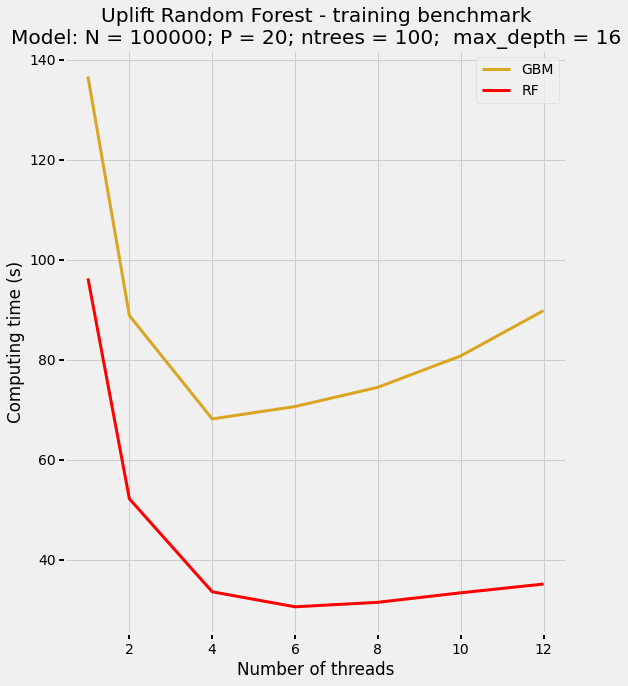

In [25]:
plot_result(gbm_time1, rf_time1)

In [26]:
N = 100000
P = 20
max_depth = 16
nbins_top_level=2500
nbins=2000
nbinss.append(nbins)

df, x_names, treatment_column, response_column = syntetic_data(N, P)

In [27]:
gbm_time2, rf_time2 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpti31gv1u
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpti31gv1u\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpti31gv1u\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,18 hours and 18 minutes
H2O_cluster_name:,H2O_from_python_potte_nmg9nj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 316.6608259677887s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 106.53077554702759s
H2O session _sid_bd8f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgt7twgai
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgt7twgai\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgt7twgai\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,18 hours and 25 minutes
H2O_cluster_name:,H2O_from_python_potte_r5194y
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 318.3548321723938s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 105.86685967445374s
H2O session _sid_b318 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcqprnjnt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcqprnjnt\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcqprnjnt\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,18 hours and 33 minutes
H2O_cluster_name:,H2O_from_python_potte_byedms
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 313.0052721500397s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 105.85808157920837s
H2O session _sid_8e0e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpve3o1_9j
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpve3o1_9j\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpve3o1_9j\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,18 hours and 40 minutes
H2O_cluster_name:,H2O_from_python_potte_iz0hkd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 311.98459792137146s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 105.43197178840637s
H2O session _sid_8ca0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcv9cc8ph
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcv9cc8ph\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcv9cc8ph\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,18 hours and 48 minutes
H2O_cluster_name:,H2O_from_python_potte_y54gii
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 313.83005952835083s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 106.4814088344574s
H2O session _sid_aa1b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpk06k2ad3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpk06k2ad3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpk06k2ad3\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,18 hours and 55 minutes
H2O_cluster_name:,H2O_from_python_potte_aqsm9e
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 313.29402232170105s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 106.16184091567993s
H2O session _sid_9df7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplq08x5z_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplq08x5z_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplq08x5z_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,19 hours and 2 minutes
H2O_cluster_name:,H2O_from_python_potte_wvhmq4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 314.883163690567s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 105.46958422660828s
H2O session _sid_b928 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpan3oztqc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpan3oztqc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpan3oztqc\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,19 hours and 10 minutes
H2O_cluster_name:,H2O_from_python_potte_dxtqel
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 318.8162944316864s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 107.87158036231995s
H2O session _sid_925c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbljjfkkj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbljjfkkj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbljjfkkj\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,19 hours and 17 minutes
H2O_cluster_name:,H2O_from_python_potte_w4hw1f
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 313.1242604255676s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 105.70814990997314s
H2O session _sid_9731 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpn711ooq5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpn711ooq5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpn711ooq5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,19 hours and 25 minutes
H2O_cluster_name:,H2O_from_python_potte_lzyzfa
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 317.88922786712646s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 105.63594150543213s
H2O session _sid_89f5 closed.
Uplift 315.1842556476593s
RF 106.10161943435669s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpm239vas3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpm239vas3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpm239vas3\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,19 hours and 32 minutes
H2O_cluster_name:,H2O_from_python_potte_ao32yo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 286.14052057266235s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 97.52031636238098s
H2O session _sid_bd31 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdgg45npm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdgg45npm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdgg45npm\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,19 hours and 39 minutes
H2O_cluster_name:,H2O_from_python_potte_1mw56o
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 292.0811171531677s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 98.62682223320007s
H2O session _sid_b068 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7uri4uq5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7uri4uq5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7uri4uq5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,19 hours and 46 minutes
H2O_cluster_name:,H2O_from_python_potte_065z37
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 288.16693687438965s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 98.74891400337219s
H2O session _sid_999e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfcbh6fy3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfcbh6fy3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfcbh6fy3\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,19 hours and 53 minutes
H2O_cluster_name:,H2O_from_python_potte_m82ueg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 286.87749767303467s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 97.67878103256226s
H2O session _sid_a58d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp76r15w56
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp76r15w56\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp76r15w56\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,19 hours and 59 minutes
H2O_cluster_name:,H2O_from_python_potte_30s5iv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 289.6779417991638s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 98.50985527038574s
H2O session _sid_81d7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpi1fj9nvd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpi1fj9nvd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpi1fj9nvd\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 hours and 6 minutes
H2O_cluster_name:,H2O_from_python_potte_mppjp4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 283.06750893592834s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 97.21448159217834s
H2O session _sid_b363 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdlh42ylq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdlh42ylq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdlh42ylq\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 hours and 13 minutes
H2O_cluster_name:,H2O_from_python_potte_a4phr5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 284.64187145233154s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 97.73820781707764s
H2O session _sid_ad59 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3t7v_gj7
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3t7v_gj7\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3t7v_gj7\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 hours and 20 minutes
H2O_cluster_name:,H2O_from_python_potte_3i9hhe
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 283.937358379364s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 96.6929624080658s
H2O session _sid_9a9e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5n0ug0gc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5n0ug0gc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5n0ug0gc\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 hours and 27 minutes
H2O_cluster_name:,H2O_from_python_potte_ti0m9r
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 289.8850328922272s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 97.37480235099792s
H2O session _sid_96d8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptemmq2ru
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptemmq2ru\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptemmq2ru\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 hours and 33 minutes
H2O_cluster_name:,H2O_from_python_potte_y3ul9w
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 286.6590430736542s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 98.60524415969849s
H2O session _sid_bed2 closed.
Uplift 287.11348288059236s
RF 97.87103872299194s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsp3a11es
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsp3a11es\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpsp3a11es\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 hours and 40 minutes
H2O_cluster_name:,H2O_from_python_potte_qw7lxp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 264.729323387146s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 89.55879735946655s
H2O session _sid_bedc closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpz4_m58be
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpz4_m58be\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpz4_m58be\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 hours and 47 minutes
H2O_cluster_name:,H2O_from_python_potte_h8t3gu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 267.2556149959564s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 91.38420391082764s
H2O session _sid_b82d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4f09_pr5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4f09_pr5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4f09_pr5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 hours and 53 minutes
H2O_cluster_name:,H2O_from_python_potte_ozx6qc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 262.77243304252625s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 90.10915327072144s
H2O session _sid_b32e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpm0fvljn0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpm0fvljn0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpm0fvljn0\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 hours and 59 minutes
H2O_cluster_name:,H2O_from_python_potte_vu2gv6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 262.3767066001892s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 90.17295360565186s
H2O session _sid_9243 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmceh1kvt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmceh1kvt\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmceh1kvt\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,21 hours and 5 minutes
H2O_cluster_name:,H2O_from_python_potte_3jrlrp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 267.00127029418945s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 90.5057578086853s
H2O session _sid_8e4f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpoh9g6h02
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpoh9g6h02\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpoh9g6h02\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,21 hours and 12 minutes
H2O_cluster_name:,H2O_from_python_potte_bv61rg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 263.23916244506836s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 90.08222460746765s
H2O session _sid_9cad closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcz8mhgfn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcz8mhgfn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcz8mhgfn\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,21 hours and 18 minutes
H2O_cluster_name:,H2O_from_python_potte_ffkdeh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 262.50621938705444s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 89.67407822608948s
H2O session _sid_adb4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprgoppm7a
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprgoppm7a\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprgoppm7a\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,21 hours and 24 minutes
H2O_cluster_name:,H2O_from_python_potte_qzv2lj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 262.18035197257996s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 90.14849519729614s
H2O session _sid_b406 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbuu_ohei
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbuu_ohei\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbuu_ohei\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,21 hours and 31 minutes
H2O_cluster_name:,H2O_from_python_potte_1pt7a0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 261.1196892261505s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 89.08936548233032s
H2O session _sid_8299 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpme8u59gi
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpme8u59gi\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpme8u59gi\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,21 hours and 37 minutes
H2O_cluster_name:,H2O_from_python_potte_ozi68m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 262.3146731853485s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 90.17522025108337s
H2O session _sid_a962 closed.
Uplift 263.5495444536209s
RF 90.09002497196198s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpy2nwm4xn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpy2nwm4xn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpy2nwm4xn\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,21 hours and 43 minutes
H2O_cluster_name:,H2O_from_python_potte_vfa4ia
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 243.38544082641602s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 84.05507826805115s
H2O session _sid_9642 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgwvmghcu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgwvmghcu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgwvmghcu\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,21 hours and 49 minutes
H2O_cluster_name:,H2O_from_python_potte_yqivgg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 241.00183987617493s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 83.74553513526917s
H2O session _sid_b355 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpli5dks_o
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpli5dks_o\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpli5dks_o\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,21 hours and 55 minutes
H2O_cluster_name:,H2O_from_python_potte_j7ui0z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 242.68334293365479s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 84.79777908325195s
H2O session _sid_a046 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvti0xcpz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvti0xcpz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvti0xcpz\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,22 hours and 1 minute
H2O_cluster_name:,H2O_from_python_potte_01wct5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 240.5120394229889s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 83.90266156196594s
H2O session _sid_9aa0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpi2z_7n71
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpi2z_7n71\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpi2z_7n71\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,22 hours and 6 minutes
H2O_cluster_name:,H2O_from_python_potte_ls7jas
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 238.755713224411s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 82.8214156627655s
H2O session _sid_90e9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpc8gwh6pp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpc8gwh6pp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpc8gwh6pp\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,22 hours and 12 minutes
H2O_cluster_name:,H2O_from_python_potte_b2410v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 242.2136731147766s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 83.76324892044067s
H2O session _sid_985a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpotzgx4t0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpotzgx4t0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpotzgx4t0\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,22 hours and 18 minutes
H2O_cluster_name:,H2O_from_python_potte_ofg38e
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 241.0359663963318s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 83.79012441635132s
H2O session _sid_a923 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpao0l920x
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpao0l920x\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpao0l920x\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,22 hours and 24 minutes
H2O_cluster_name:,H2O_from_python_potte_ba3zuy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 243.5013267993927s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 84.28576922416687s
H2O session _sid_b61b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphq985538
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphq985538\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphq985538\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,22 hours and 30 minutes
H2O_cluster_name:,H2O_from_python_potte_nqst2f
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 239.9379539489746s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 83.90439057350159s
H2O session _sid_872b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0xu4nf_v
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0xu4nf_v\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0xu4nf_v\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,22 hours and 36 minutes
H2O_cluster_name:,H2O_from_python_potte_0k3tjt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 240.35532975196838s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 82.81117796897888s
H2O session _sid_8d63 closed.
Uplift 241.33826262950896s
RF 83.78771808147431s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_ytngryg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_ytngryg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_ytngryg\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server a

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,22 hours and 41 minutes
H2O_cluster_name:,H2O_from_python_potte_fjtt7f
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 226.83982753753662s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 85.98641562461853s
H2O session _sid_a4df closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpec_qos8k
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpec_qos8k\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpec_qos8k\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,22 hours and 47 minutes
H2O_cluster_name:,H2O_from_python_potte_tuy3b8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 219.07621788978577s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 83.4051022529602s
H2O session _sid_b4e1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpoh2yspoy
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpoh2yspoy\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpoh2yspoy\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,22 hours and 52 minutes
H2O_cluster_name:,H2O_from_python_potte_8lcfnm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 225.66833758354187s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 85.58679866790771s
H2O session _sid_8bd3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpe7hxf_kg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpe7hxf_kg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpe7hxf_kg\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,22 hours and 58 minutes
H2O_cluster_name:,H2O_from_python_potte_3yqdvp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 226.67275381088257s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 86.8901629447937s
H2O session _sid_ab2e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp233oj9gj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp233oj9gj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp233oj9gj\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,23 hours and 4 minutes
H2O_cluster_name:,H2O_from_python_potte_kshj1p
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 222.23530864715576s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 84.48851656913757s
H2O session _sid_9e3c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnu2k1w9z
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnu2k1w9z\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnu2k1w9z\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,23 hours and 9 minutes
H2O_cluster_name:,H2O_from_python_potte_vz8vl5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 224.4059774875641s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 87.19514060020447s
H2O session _sid_bb75 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpq4s820k6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpq4s820k6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpq4s820k6\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,23 hours and 15 minutes
H2O_cluster_name:,H2O_from_python_potte_1cas4g
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 218.72930073738098s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 83.58124041557312s
H2O session _sid_b8f1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpv_zrh0vl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpv_zrh0vl\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpv_zrh0vl\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,23 hours and 20 minutes
H2O_cluster_name:,H2O_from_python_potte_f5te7b
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 226.48007154464722s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 85.98039889335632s
H2O session _sid_9e81 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpat_tkd0s
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpat_tkd0s\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpat_tkd0s\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,23 hours and 26 minutes
H2O_cluster_name:,H2O_from_python_potte_spnqlv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 222.1246919631958s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 83.97552394866943s
H2O session _sid_bc73 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4n763dr0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4n763dr0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4n763dr0\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,23 hours and 31 minutes
H2O_cluster_name:,H2O_from_python_potte_al3sd5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 221.56693577766418s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 84.80734324455261s
H2O session _sid_af01 closed.
Uplift 223.3799422979355s
RF 85.18966431617737s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpehpret8z
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpehpret8z\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpehpret8z\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,23 hours and 37 minutes
H2O_cluster_name:,H2O_from_python_potte_dlgpls
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 252.62891507148743s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 119.39536881446838s
H2O session _sid_9776 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp83ry8x_d
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp83ry8x_d\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp83ry8x_d\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,23 hours and 43 minutes
H2O_cluster_name:,H2O_from_python_potte_9xl8e8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 249.0471441745758s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 117.73452305793762s
H2O session _sid_8a47 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpyndkwjsq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpyndkwjsq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpyndkwjsq\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,23 hours and 50 minutes
H2O_cluster_name:,H2O_from_python_potte_78ov0m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 252.82344579696655s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 117.47031235694885s
H2O session _sid_95ae closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9c_e6ji3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9c_e6ji3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9c_e6ji3\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,23 hours and 56 minutes
H2O_cluster_name:,H2O_from_python_potte_zrafrr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 256.2691774368286s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 119.95077705383301s
H2O session _sid_9c12 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2g6zici4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2g6zici4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2g6zici4\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_hkp7cl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 253.0937306880951s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 119.530930519104s
H2O session _sid_9787 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpx0ny1sqc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpx0ny1sqc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpx0ny1sqc\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_jpnsdr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 252.58276510238647s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 119.4319007396698s
H2O session _sid_b8f9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdwr6pkyl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdwr6pkyl\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdwr6pkyl\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_21nysn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 260.51628160476685s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 123.29264497756958s
H2O session _sid_a029 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmon02z8i
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmon02z8i\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmon02z8i\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_qjwe8f
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 254.61994242668152s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 118.84816098213196s
H2O session _sid_8382 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplg114299
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplg114299\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplg114299\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_akolae
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 246.8720362186432s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 116.40617108345032s
H2O session _sid_95ef closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8gj3ejpn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8gj3ejpn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8gj3ejpn\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_wnp11r
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 253.60845398902893s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 118.39410543441772s
H2O session _sid_ae4b closed.
Uplift 253.20618925094604s
RF 119.04548950195313s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpb5ur1il5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpb5ur1il5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpb5ur1il5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_cfp6np
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 371.66366481781006s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 216.73043131828308s
H2O session _sid_896e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpowujf9zu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpowujf9zu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpowujf9zu\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_8lwt0n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 374.34815740585327s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 217.70664048194885s
H2O session _sid_aea0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmploh6d777
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmploh6d777\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmploh6d777\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_w8q0pl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 388.8703935146332s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 224.84982442855835s
H2O session _sid_bea9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpr280rgt6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpr280rgt6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpr280rgt6\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_thk1zd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 390.30197072029114s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 224.51190733909607s
H2O session _sid_b654 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptq5qksyk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptq5qksyk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptq5qksyk\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_vq9uu1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 385.74843978881836s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 223.144793510437s
H2O session _sid_9a79 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpy5nocqth
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpy5nocqth\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpy5nocqth\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_pkh87j
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 372.0417058467865s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 218.0186653137207s
H2O session _sid_970e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp210z0ppi
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp210z0ppi\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp210z0ppi\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_lkq02n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 369.28632831573486s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 215.58898901939392s
H2O session _sid_96da closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpj7xm2e7b
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpj7xm2e7b\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpj7xm2e7b\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_mhfs8s
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 375.1045608520508s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 217.96177697181702s
H2O session _sid_b2bb closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_0a7w230
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_0a7w230\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_0a7w230\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ezs4mh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 389.12827944755554s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 225.1253626346588s
H2O session _sid_a132 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9kwmdbbo
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9kwmdbbo\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9kwmdbbo\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_5y928q
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 389.46385860443115s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 224.54830718040466s
H2O session _sid_99dc closed.
Uplift 380.59573593139646s
RF 220.81866981983185s
12 - Uplift = 315.1842556476593, RF = 106.10161943435669
10 - Uplift = 287.11348288059236, RF = 97.87103872299194
8 - Uplift = 263.5495444536209, RF = 90.09002497196198
6 - Uplift = 241.33826262950896, RF = 83.78771808147431
4 - Uplift = 223.3799422979355, RF = 85.18966431617737
2 - Uplift = 253.20618925094604, RF = 119.04548950195313
1 - Uplift = 380.59573593139646, RF = 220.81866981983185


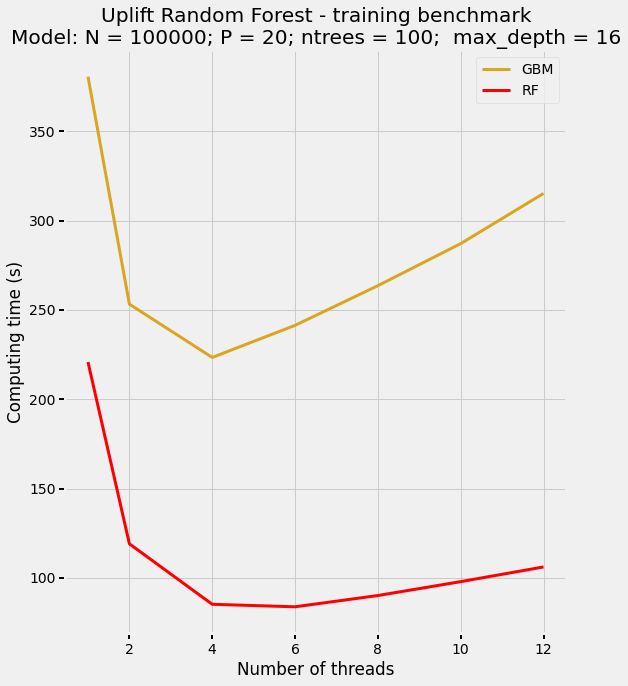

In [28]:
plot_result(gbm_time2, rf_time2)

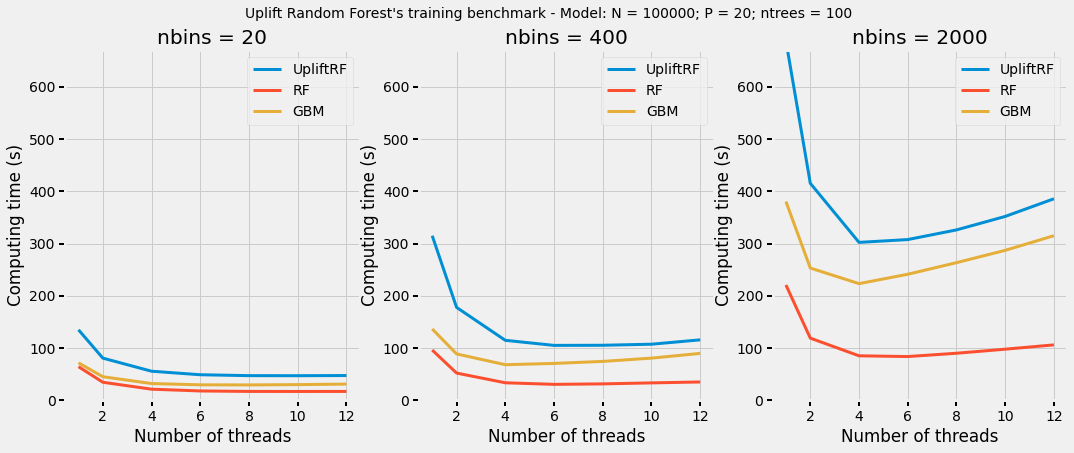

In [29]:
all_predict_uplift = [{12: 47.41590563456217, 10: 47.09019978841146, 8: 47.20285773277283, 6: 48.934909184773765, 4: 55.68334444363912, 2: 80.77636043230693, 1: 135.0319495598475}, {12: 115.73719743887584, 10: 107.39745060602824, 8: 105.37701443831126, 6: 105.14607735474904, 4: 114.84956920146942, 2: 177.93514688809714, 1: 315.1645288467407}, {12: 385.8683665196101, 10: 352.0414063135783, 8: 326.2400721311569, 6: 307.7587921222051, 4: 302.36467655499774, 2: 415.5071925719579, 1: 687.9979410171509}]
all_predict_gbm = [gbm_time0, gbm_time1, gbm_time2]
all_predict_rf = [rf_time0, rf_time1, rf_time2]

fig=plt.figure(figsize=(16,6))
fig.suptitle(f"Uplift Random Forest's training benchmark - Model: N = {N}; P = {P}; ntrees = {ntrees}", fontsize=14)

for uplift_time, rf_time, gbm_time, i in zip(all_predict_uplift, all_predict_rf, all_predict_gbm, range(1, len(nbinss) + 1)):
    fig.add_subplot(130 + i)
    data = {"x":[], "y": [], "label":[]}
    for label, coord in uplift_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"UpliftRF", linewidth=3)

    data = {"x":[], "y": [], "label":[]}
    for label, coord in rf_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"RF", linewidth=3)    
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in gbm_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"GBM", linewidth=3)  
    
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.ylim(0, 670)
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"nbins = {nbinss[i - 1]}")

plt.savefig(f"h2o-train-perf-nbins{random.random()}.png", bbox_inches='tight', pad_inches=.05)
plt.show()

In [30]:
print(all_predict_uplift)

[{12: 47.41590563456217, 10: 47.09019978841146, 8: 47.20285773277283, 6: 48.934909184773765, 4: 55.68334444363912, 2: 80.77636043230693, 1: 135.0319495598475}, {12: 115.73719743887584, 10: 107.39745060602824, 8: 105.37701443831126, 6: 105.14607735474904, 4: 114.84956920146942, 2: 177.93514688809714, 1: 315.1645288467407}, {12: 385.8683665196101, 10: 352.0414063135783, 8: 326.2400721311569, 6: 307.7587921222051, 4: 302.36467655499774, 2: 415.5071925719579, 1: 687.9979410171509}]


In [31]:
print(all_predict_gbm)

[{12: 31.045402455329896, 10: 30.003125166893007, 8: 29.459724402427675, 6: 29.618798065185548, 4: 32.065751457214354, 2: 45.13592867851257, 1: 71.67515115737915}, {12: 89.81329185962677, 10: 80.74043428897858, 8: 74.46653089523315, 6: 70.61683766841888, 4: 68.13480970859527, 2: 88.81703267097473, 1: 136.62510740756989}, {12: 315.1842556476593, 10: 287.11348288059236, 8: 263.5495444536209, 6: 241.33826262950896, 4: 223.3799422979355, 2: 253.20618925094604, 1: 380.59573593139646}]


In [32]:
print(all_predict_rf)

[{12: 16.969228744506836, 10: 16.93504798412323, 8: 16.9992112159729, 6: 17.891290044784547, 4: 21.27529604434967, 2: 34.54790048599243, 1: 64.3570431470871}, {12: 35.09399790763855, 10: 33.34315853118896, 8: 31.443611669540406, 6: 30.545160150527956, 4: 33.5466162443161, 2: 52.15320856571198, 1: 96.24524054527282}, {12: 106.10161943435669, 10: 97.87103872299194, 8: 90.09002497196198, 6: 83.78771808147431, 4: 85.18966431617737, 2: 119.04548950195313, 1: 220.81866981983185}]


## Evaluation Stage

In [33]:
def run_predict(EIF_model, IF_model, hf_test):
    start = time.time()
    EIF_model.predict(hf_test)
    end = time.time()
    eif_time = end - start
    print(f"EIF Time: {eif_time}s")
    start = time.time()
    IF_model.predict(hf_test)
    end = time.time()
    if_time = end - start
    print(f"IF Time: {if_time}s")    
    return eif_time, if_time


def run_predict_benchmark(train_data, test_data):
    all_times = []
    all_times_num_eif = []
    all_times_num_if = []
    for nthreads in threds:
        times_eif = []
        times_if = []
        h2o.init(nthreads=nthreads)     
        hf_train = h2o.H2OFrame(train_data)    
        hf_test = h2o.H2OFrame(test_data)
        EIF_model = H2OExtendedIsolationForestEstimator(model_id = "extended_isolation_forest.hex",
                                             ntrees = ntrees, seed = seed, sample_size = sample_size, extension_level = P - 1)
        EIF_model.train(training_frame = hf_train)
        IF_model = H2OIsolationForestEstimator(model_id = "isolation_forest.hex",
                                         ntrees = ntrees, seed = seed, sample_size = sample_size, max_depth = max_depth+1)
        IF_model.train(training_frame = hf_train)
        for i in range(attempt_per_thread):
            eif_time, if_time = run_predict(EIF_model, IF_model, hf_test)
            times_eif.append(eif_time)
            times_if.append(if_time)
        h2o.cluster().shutdown()
        print(f"EIF {np.mean(times_eif)}s")
        print(f"IF {np.mean(times_if)}s")
        all_times_num_eif.append(times_eif)
        all_times_num_if.append(times_if)
        all_times.append(f"thread {nthreads} - EIF {np.mean(times_eif)}s and IF {np.mean(times_if)}s")
        
        
    eif_means = dict()
    if_means = dict()
    for i, nthreads in enumerate(threds):
        print(f"{nthreads} - EIF = {np.mean(all_times_num_eif[i])}, IF = {np.mean(all_times_num_if[i])}")
        eif_means[nthreads] = np.mean(all_times_num_eif[i])
        if_means[nthreads] = np.mean(all_times_num_if[i])

    return eif_means, if_means 

def plot_predict(EIF_means, IF_means):
    data = {"x":[], "y": [], "label":[]}
    for label, coord in EIF_means.items():
        data["x"].append(label)
        data["y"].append(coord)

    data_if = {"x":[], "y": [], "label":[]}
    for label, coord in IF_means.items():
        data_if["x"].append(label)
        data_if["y"].append(coord)    

    fig=plt.figure(figsize=(8,10))
    fig.add_subplot(111)
    plt.plot(data['x'], data['y'], '-', label="EIF", linewidth=3)
    plt.plot(data_if['x'], data_if['y'], '-', label="IF", linewidth=3)
    # plt.grid("off")
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"Extended Isolation Forest - evaluation benchmark\nModel: N = {N_train}; P = {P}; ntrees = {ntrees}; sample_size = {sample_size};  max_depth = {max_depth}\nEvaluation Frame: N = {N}; P = {P}")
    plt.savefig(f"h2o-eval-perf_{sample_size}_{N}_{coord}.png", bbox_inches='tight', pad_inches=.05)
    plt.show()

In [34]:
# Evaluation stage parameters

N = 500
P = 2
N_train = 500
sample_size = 256
max_depth = math.ceil(math.log(sample_size, 2))

blobs_params = dict(random_state=seed, n_samples=N_train, n_features=P)
X_train = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

blobs_params = dict(random_state=seed, n_samples=N, n_features=P)
X_test = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

eif_time18, if_time18 = run_predict_benchmark(X_train, X_test)

NameError: name 'make_blobs' is not defined

In [ ]:
plot_predict(eif_time18, if_time18)

In [ ]:
# Evaluation stage parameters

N = 500_000
P = 30
N_train = 500_000
sample_size = 256
max_depth = math.ceil(math.log(sample_size, 2))

blobs_params = dict(random_state=seed, n_samples=N_train, n_features=P)
X_train = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

blobs_params = dict(random_state=seed, n_samples=N, n_features=P)
X_test = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

eif_time10, if_time10 = run_predict_benchmark(X_train, X_test)

In [ ]:
plot_predict(eif_time10, if_time10)

In [ ]:
# Evaluation stage parameters

N = 500_000
P = 40
N_train = 500_000
sample_size = 5_000
max_depth = math.ceil(math.log(sample_size, 2))

blobs_params = dict(random_state=seed, n_samples=N_train, n_features=P)
X_train = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

blobs_params = dict(random_state=seed, n_samples=N, n_features=P)
X_test = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

eif_time11, if_time11 = run_predict_benchmark(X_train, X_test)

In [ ]:
plot_predict(eif_time11, if_time11)

In [ ]:
# Evaluation stage parameters

N = 500_000
P = 40
N_train = 500_000
sample_size = 20_000
max_depth = math.ceil(math.log(sample_size, 2))

blobs_params = dict(random_state=seed, n_samples=N_train, n_features=P)
X_train = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

blobs_params = dict(random_state=seed, n_samples=N, n_features=P)
X_test = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

eif_time12, if_time12 = run_predict_benchmark(X_train, X_test)

In [ ]:
plot_predict(eif_time12, if_time12)

### Real Credit Card Fraud Detection Data

In [ ]:
sample_sizes = []

In [ ]:
# Evaluation stage parameters

# Real data parameters

df = pd.read_csv("../creditcard.csv", nrows=1)
columns = df.columns.tolist()
cols_to_use = columns[:len(columns)-1]
df = pd.read_csv("../creditcard.csv", usecols=cols_to_use)

N = df.shape[0]
N_train = df.shape[0]
P = df.shape[1]
sample_size = 256
sample_sizes.append(sample_size)
max_depth = math.ceil(math.log(sample_size, 2))

print(N, P, sample_size, max_depth)

eif_time14, if_time14 = run_predict_benchmark(df, df)

In [ ]:
plot_predict(eif_time14, if_time14)

In [ ]:
# Evaluation stage parameters

# Real data parameters

df = pd.read_csv("../creditcard.csv", nrows=1)
columns = df.columns.tolist()
cols_to_use = columns[:len(columns)-1]
df = pd.read_csv("../creditcard.csv", usecols=cols_to_use)

N = df.shape[0]
N_train = df.shape[0]
P = df.shape[1]
sample_size = int(df.shape[0] * 0.01)
sample_sizes.append(sample_size)
max_depth = math.ceil(math.log(sample_size, 2))

print(N, P, sample_size, max_depth)

eif_time15, if_time15 = run_predict_benchmark(df, df)

In [ ]:
plot_predict(eif_time15, if_time15)

In [ ]:
# Evaluation stage parameters

# Real data parameters

df = pd.read_csv("../creditcard.csv", nrows=1)
columns = df.columns.tolist()
cols_to_use = columns[:len(columns)-1]
df = pd.read_csv("../creditcard.csv", usecols=cols_to_use)

N = df.shape[0]
N_train = df.shape[0]
P = df.shape[1]
sample_size = int(df.shape[0] * 0.05)
sample_sizes.append(sample_size)
max_depth = math.ceil(math.log(sample_size, 2))

print(N, P, sample_size, max_depth)

eif_time16, if_time16 = run_predict_benchmark(df, df)

In [ ]:
plot_predict(eif_time16, if_time16)

In [ ]:
# Evaluation stage parameters

# Real data parameters

df = pd.read_csv("../creditcard.csv", nrows=1)
columns = df.columns.tolist()
cols_to_use = columns[:len(columns)-1]
df = pd.read_csv("../creditcard.csv", usecols=cols_to_use)

N = df.shape[0]
N_train = df.shape[0]
P = df.shape[1]
sample_size = int(df.shape[0] * 0.10)
sample_sizes.append(sample_size)
max_depth = math.ceil(math.log(sample_size, 2))

print(N, P, sample_size, max_depth)

eif_time17, if_time17 = run_predict_benchmark(df, df)

In [ ]:
plot_predict(eif_time17, if_time17)

In [ ]:
all_predict_eif = [eif_time14, eif_time15, eif_time16]
all_predict_if = [if_time14, if_time15, if_time16]

fig=plt.figure(figsize=(16,6))
fig.suptitle(f"Extended Isolation Forest's scoring benchmark - Frame to score: N = {N}; P = {P}. Model: N = {N_train}; P = {P}; ntrees = {ntrees}.", fontsize=14)

for eif_time, if_time, i in zip(all_predict_eif, all_predict_if, range(1, len(sample_sizes) + 1)):
    fig.add_subplot(130 + i)
    data = {"x":[], "y": [], "label":[]}
    for label, coord in eif_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"EIF", linewidth=3)

    data = {"x":[], "y": [], "label":[]}
    for label, coord in if_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"IF", linewidth=3)    
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.ylim(0, 40)
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"sample_size = {sample_sizes[i - 1]}; max_depth = {math.ceil(math.log(sample_sizes[i - 1], 2))}")

plt.savefig(f"h2o-score-perf_credit{random.random()}.png", bbox_inches='tight', pad_inches=.05)
plt.show()